In [1]:
import uproot as up
import awkward as ak
import pandas as pd
from scipy.optimize import curve_fit

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
import time
from pathlib import Path

import mplhep as hep
hep.style.use('ROOT')


In [3]:
class Analysis:
    '''
    This class fills a dictionary masks for testing various hit and event level cuts
    Includes a function to combine hit and event level cuts together 
    Returns the charges of the hits that pass all specified event and hit level cuts
    Also returns the number of hits taht pass all specified event and hit level cuts as a function of pmt id 
    '''
    
    def __init__(self, file_path, nevents=None):
        self.file_path = Path(file_path)
        self.nevents = nevents
        # Raw data 
        self.meta_data = None
        self.output_data = None
        # Stuff to calculate 
        self.hit_time_res = None
        self.hit_tof = None
        self.low_energy_dt = None
        self.coinc_hit_counts = None
        self.coinc_hit_err = None
        # PMT groupings
        self.pmt_channels = {}
        self.pmt_is_online = None
        # Cut masks 
        self.masks = {}  
        self.mask_type = {}
        
    def print_file_info(self):
        f = up.open(self.file_path)
        print(f"File: {self.file_path}")
        print(f"Loading: {self.nevents or 'all'} of {f['output'].num_entries} events")
        
    def load_meta_data(self):
        f = up.open(self.file_path)
        print(f"Meta Keys: {f['meta'].keys()}")
        start = time.time()
        self.meta_data = f['meta'].arrays([
            'pmtId', 'pmtChannel', 'pmtIsOnline',
            'pmtX', 'pmtY', 'pmtZ'
        ], entry_start=0, entry_stop=1, library='ak')
        stop = time.time()
        print(f"Loaded meta data in {stop-start:.2f} seconds")
        self.setup_pmt_channels()
     
    def load_event_data(self):
        f = up.open(self.file_path)
        print(f"Output Keys: {f['output'].keys()}")
        start = time.time()
        self.output_data = f['output'].arrays([
            'timeSinceLastTrigger_us',
            'digitHitCleaningMask', 
            'fit_pmtid_Lognormal', 'fit_time_Lognormal', 'fit_charge_Lognormal', 
            'x_seedndestroy', 'y_seedndestroy', 'z_seedndestroy', 'time_seedndestroy', 
            'validposition_seedndestroy', 'validtime_seedndestroy'
        ], entry_start=0, entry_stop=self.nevents, library='ak')
        stop = time.time()
        print(f"Loaded event data in {stop-start:.2f} seconds")
    
    def setup_pmt_channels(self):
        if self.meta_data is None:
            raise RuntimeError("Meta data must be loaded first")
        board_configs = {
            'barrel': [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11],
            'top': [12, 13],
            'dichroic': [7],
            'bottom': [14, 15],
            'behind': [16]  # only 13 channels 
        }
        for region, boards in board_configs.items():
            channels = []
            for board in boards:
                n_channels = 13 if (region == 'behind') else 16
                channels.extend([16 * board + i for i in range(n_channels)])
            self.pmt_channels[region] = channels
    
    def calculate_time_residuals(self):
        if self.output_data is None:
            raise RuntimeError("Event data must be loaded first")
        # Event fit results 
        event_time = self.output_data['time_seedndestroy']
        fitx = ak.broadcast_arrays(self.output_data['fit_pmtid_Lognormal'], self.output_data['x_seedndestroy'])[1]
        fity = ak.broadcast_arrays(self.output_data['fit_pmtid_Lognormal'], self.output_data['y_seedndestroy'])[1]
        fitz = ak.broadcast_arrays(self.output_data['fit_pmtid_Lognormal'], self.output_data['z_seedndestroy'])[1]
        valid_fit = (self.output_data['validtime_seedndestroy'] & self.output_data['validposition_seedndestroy'])
        # Hit results 
        hit_time = self.output_data['fit_time_Lognormal']
        event_time = ak.broadcast_arrays(hit_time, event_time)[1]
        # Get PMT positions
        pmtX = ak.Array(self.meta_data['pmtX'][0])
        pmtY = ak.Array(self.meta_data['pmtY'][0])
        pmtZ = ak.Array(self.meta_data['pmtZ'][0])
        # Map PMT positions to hits
        hitx_flat = pmtX[ak.flatten(self.output_data['fit_pmtid_Lognormal'])]
        hity_flat = pmtY[ak.flatten(self.output_data['fit_pmtid_Lognormal'])]
        hitz_flat = pmtZ[ak.flatten(self.output_data['fit_pmtid_Lognormal'])]
        hitx = ak.unflatten(hitx_flat, ak.num(self.output_data['fit_pmtid_Lognormal']))
        hity = ak.unflatten(hity_flat, ak.num(self.output_data['fit_pmtid_Lognormal']))
        hitz = ak.unflatten(hitz_flat, ak.num(self.output_data['fit_pmtid_Lognormal']))
        # Calculate time of flight
        dist = np.sqrt((fitx - hitx)**2 + (fity - hity)**2 + (fitz - hitz)**2)
        hit_tof = dist / 224  # speed of light in water [mm/ns]
        self.hit_tof = hit_tof
        # Calculate time residuals
        hit_time_res = hit_time - event_time - hit_tof
        valid_fit = ak.broadcast_arrays(hit_time, valid_fit)[1]
        self.hit_time_res = ak.where(valid_fit, hit_time_res, np.nan)
    
    def create_hit_amplitude_mask(self, mask_name='hit_amplitude'):
        mask = ((self.output_data['digitHitCleaningMask'] >> 1) & 1) == 0
        self.masks[mask_name] = mask
        self.mask_type[mask_name] = 'hit'
        return mask
    
    def create_hit_charge_mask(self, min_charge=0, mask_name='hit_charge'):
        charge = self.output_data['fit_charge_Lognormal']
        mask = charge > min_charge
        self.masks[mask_name] = mask
        self.mask_type[mask_name] = 'hit'
        return mask
    
    def create_hit_time_mask(self, time_range=(-10, 10), mask_name='hit_time'):
        if self.hit_time_res is None:
            raise RuntimeError("Time residuals must be calculated first")
        mask = ((self.hit_time_res > time_range[0]) & 
                (self.hit_time_res < time_range[1]))
        self.masks[mask_name] = mask
        self.mask_type[mask_name] = 'hit'
        return mask
    
    def create_fiducial_volume_mask(self, z_cut=600, r_cut=600, mask_name='fiducial'):
        x_fit = self.output_data['x_seedndestroy']
        y_fit = self.output_data['y_seedndestroy'] 
        z_fit = self.output_data['z_seedndestroy']
        valid_fit = (self.output_data['validtime_seedndestroy'] & self.output_data['validposition_seedndestroy'])
        mask = ((z_cut > z_fit) & (z_fit > -z_cut) & 
                (r_cut > np.sqrt(x_fit**2 + y_fit**2)) &
                valid_fit)
        self.masks[mask_name] = mask
        self.mask_type[mask_name] = 'event'
        return mask
    
    def calculate_nhits(self, hit_masks=None):
        charges = self.output_data['fit_charge_Lognormal']
        if hit_masks:
            combined_mask = self.combine_masks(hit_masks, mask_type='hit')
            charges = ak.mask(charges, combined_mask)
        return ak.count(charges, axis=1)
    
    # Masks based on nhit thresholds 
    def create_energy_masks(self, high_energy_min=125, low_energy_min=50, hit_masks=None, high_name='high_energy',low_name='low_energy'):
        nhits = self.calculate_nhits(hit_masks)
        high_energy_mask = nhits >= high_energy_min
        low_energy_mask = (nhits >= low_energy_min) & (nhits < high_energy_min)
        self.masks[high_name] = high_energy_mask
        self.mask_type[high_name] = 'event'
        self.masks[low_name] = low_energy_mask
        self.mask_type[low_name] = 'event'
        return high_energy_mask, low_energy_mask

    # Only keeps pairs of one prompt with one delayed 
    # Throw away if there was multiple prompt or delayed in the window
    def compute_low_energy_delayed_times(self,high_name,low_name,min_time_window_us=0.8,max_time_window_us=400):
        high_indices = set(np.where(self.masks[high_name])[0])
        low_indices = set(np.where(self.masks[low_name])[0])
        dt_us = np.array(self.output_data['timeSinceLastTrigger_us'])
        skip_indices = set()  # Events to skip (already processed)
        delta_ts = []
        # Loop through all events
        for i in range(len(dt_us)):
            # Skip if already used
            if i in skip_indices:
                continue
            # Only process high energy events
            if i not in high_indices:
                # But if its a low make it a nan (should never come first)
                if i in low_indices:
                    delta_ts.append(np.nan)
                continue
            # Look forward in the window
            j = i + 1
            cumulative_time = 0
            low_found = []
            high_found = []
            while j < len(dt_us):
                cumulative_time += dt_us[j]
                # Stop if exceeded time window
                if cumulative_time > max_time_window_us:
                    break
                # Don't want to double count it
                skip_indices.add(j)
                # See if high or low, don't care about other 
                if j in low_indices: 
                    low_found.append(cumulative_time)
                if j in high_indices:
                    high_found.append(cumulative_time)
                j += 1
            # If there was another high or more than one low throw away 
            if len(high_found)>0 or len(low_found)!=1:
                for k in range(len(low_found)):
                    delta_ts.append(np.nan) 
                continue
            else:
                # Only keep if it was between min and max
                if min_time_window_us < low_found[0] < max_time_window_us: 
                    delta_ts.append(low_found[0])
                else:
                    delta_ts.append(np.nan)
            self.low_energy_dt = np.array(delta_ts)
        return self.low_energy_dt
        
    # Michel and background masks using time between events, only considers low energy events whose nhit was within certain range 
    def create_low_energy_time_masks(self, michel_range=(1, 5), background_range=(15, 20),low_energy_mask_name='low_energy',michel_name='michel',background_name='background'):
        if self.low_energy_dt is None:
            raise RuntimeError("Delayed times must be computed first")
        low_energy_mask = self.masks[low_energy_mask_name]
        dt_us = self.low_energy_dt
        # Create time masks (only for low energy events)
        michel_time_mask = ((michel_range[0] < dt_us) & (dt_us <= michel_range[1]))
        background_time_mask = ((background_range[0] < dt_us) & (dt_us < background_range[1]))
        # Make blank masks for all events 
        michel_mask = np.zeros(len(self.output_data['timeSinceLastTrigger_us']), dtype=bool)
        background_mask = np.zeros(len(self.output_data['timeSinceLastTrigger_us']), dtype=bool)
        # Get low energy event indicies using desired time mask 
        low_energy_indices = np.where(low_energy_mask)[0]
        valid_michel_indices = low_energy_indices[michel_time_mask & ~np.isnan(dt_us)] 
        valid_background_indices = low_energy_indices[background_time_mask & ~np.isnan(dt_us)] 
        # Set those indicies to True 
        michel_mask[valid_michel_indices] = True
        background_mask[valid_background_indices] = True
        # Store masks
        self.masks[michel_name] = michel_mask
        self.mask_type[michel_name] = 'event'
        self.masks[background_name] = background_mask
        self.mask_type[background_name] = 'event' 
        return michel_mask, background_mask

    # Combine multiple masks of same type (hit or event) 
    def combine_masks(self, mask_names, mask_type=None):
        if not mask_names:
            return None
            
        if mask_type:
            for name in mask_names:
                if self.mask_type[name] != mask_type:
                    raise ValueError(f"Mask {name} is not of type {mask_type}")
                    
        combined = self.masks[mask_names[0]]
        for name in mask_names[1:]:
            combined = combined & self.masks[name]
        return combined
    
    def get_hit_charges(self, hit_masks=None, event_masks=None):
        charges = self.output_data['fit_charge_Lognormal']
        
        if hit_masks:
            hit_mask = self.combine_masks(hit_masks, mask_type='hit')
            charges = ak.mask(charges, hit_mask)
            
        if event_masks:
            event_mask = self.combine_masks(event_masks, mask_type='event')
            charges = charges[event_mask]
            
        return charges
    
    def get_nhits(self, hit_masks=None, event_masks=None):
        charges = self.get_hit_charges(hit_masks, event_masks)
        return ak.count(charges, axis=1)
    
    def compute_coincident_hits(self, hit_masks=None, event_masks=None, normalize_by_events=True):
        # Get PMT mappings
        pmt_ids = self.meta_data['pmtId'][0]
        pmt_chs = self.meta_data['pmtChannel'][0] 
        id2ch = dict(zip(pmt_ids, pmt_chs))
        ch2id = dict(zip(pmt_chs, pmt_ids))
        # Start with all PMT IDs
        clean_ids = self.output_data['fit_pmtid_Lognormal']
        # Apply hit masks
        if hit_masks:
            hit_mask = self.combine_masks(hit_masks, mask_type='hit')
            clean_ids = clean_ids[hit_mask]
        # Apply event masks  
        if event_masks:
            event_mask = self.combine_masks(event_masks, mask_type='event')
            clean_ids = clean_ids[event_mask]
        nevents = len(clean_ids)
        # Count hits per channel
        flat_clean_ids = ak.to_numpy(ak.flatten(clean_ids))
        flat_clean_lcns = np.array([id2ch[id] for id in flat_clean_ids])
        pmt_hit_counts = np.bincount(flat_clean_lcns, minlength=np.max(pmt_chs)+1)
        if normalize_by_events and nevents > 0:
            self.coinc_hit_counts = pmt_hit_counts / nevents
            self.coinc_hit_err = np.sqrt(pmt_hit_counts) / nevents
        else:
            self.coinc_hit_counts = pmt_hit_counts
            self.coinc_hit_err = np.sqrt(pmt_hit_counts)
        # Update PMT online status
        active_lcns = np.nonzero(pmt_hit_counts)[0]
        active_ids = [ch2id[lcn] for lcn in active_lcns if lcn in ch2id]
        n_pmts = max(ch2id.values()) + 1
        self.pmt_is_online = np.zeros(n_pmts, dtype=bool)
        self.pmt_is_online[active_ids] = True
        return self.coinc_hit_counts, self.coinc_hit_err 
    

                

In [9]:

file_run3056 = '/nfs/disk1/eos/eos-processed-data-dev/rat_processed_data_sum/run3056/data-3056.root' # water cosmics long run 
file_mc3056 = "/nfs/disk1/users/bharris/eos/sim/outputs/michelMCrun3056_1M/michel1M.ntuple.root"
file_mcRef3056 = "/nfs/disk1/users/bharris/eos/sim/outputs/michelMCrun3056Reflect/michel100kReflect.ntuple.root"

In [ ]:
# Initialize and load data
run = Analysis(file_run3056, nevents=5000576)
mc = Analysis(file_mc3056, nevents=1000000)

run.print_file_info()
run.load_meta_data()
run.load_event_data()

mc.print_file_info()
mc.load_meta_data()
mc.load_event_data()


File: /nfs/disk1/eos/eos-processed-data-dev/rat_processed_data_sum/run3056/data-3056.root
Loading: 5000576 of 5000576 events
Meta Keys: ['runId', 'runType', 'runTime', 'dsentries', 'macro', 'pmtType', 'pmtId', 'pmtChannel', 'pmtIsOnline', 'pmtCableOffset', 'pmtChargeScale', 'pmtPulseWidthScale', 'pmtX', 'pmtY', 'pmtZ', 'pmtU', 'pmtV', 'pmtW', 'digitizerWindowSize', 'digitizerSampleRate_GHz', 'digitizerDynamicRange_mV', 'digitizerResolution_mVPerADC', 'calibId', 'calibMode', 'calibIntensity', 'calibWavelength', 'calibName', 'calibTime', 'calibX', 'calibY', 'calibZ', 'calibU', 'calibV', 'calibW', 'geo_index', 'geo_file', 'experiment', 'source_pos_x', 'source_pos_y', 'source_pos_z', 'source_rot_x', 'source_rot_y', 'source_rot_z']
Loaded meta data in 0.01 seconds
Output Keys: ['mcpdg', 'mcx', 'mcy', 'mcz', 'mcu', 'mcv', 'mcw', 'mcke', 'mct', 'evid', 'subev', 'nhits', 'triggerTime', 'timestamp', 'trigger_word', 'event_cleaning_word', 'timeSinceLastTrigger_us', 'mcid', 'mcparticlecount', 'mc

In [ ]:
run.create_hit_amplitude_mask()
run.create_hit_charge_mask(min_charge=0)
run.calculate_time_residuals()


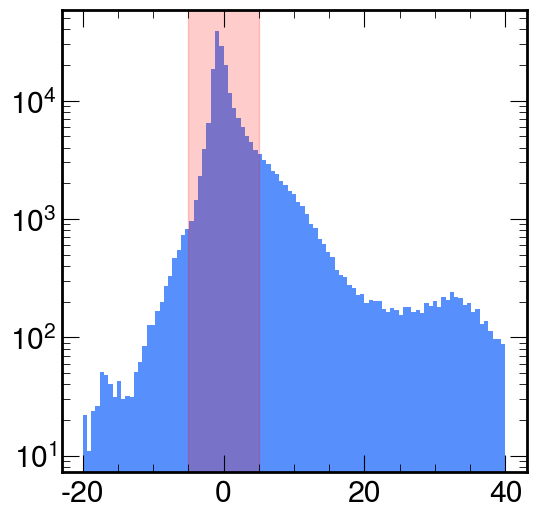

In [ ]:
tcut = (-5,5)
plt.figure(figsize=(6,6))
plt.hist(ak.flatten(run.hit_time_res),np.linspace(-20,40,100));
plt.axvspan(tcut[0],tcut[1],color='red',alpha=0.2)
plt.yscale('log')

In [ ]:

time_range = tcut
run.create_hit_time_mask(time_range=time_range);



FieldNotFoundError: no field 'timestamp' in record with 11 fields

This error occurred while attempting to slice

    <Array [{...}, {...}, ..., {...}, {...}] type='5000 * {timeSinceLastTri...'>

with

    'timestamp'

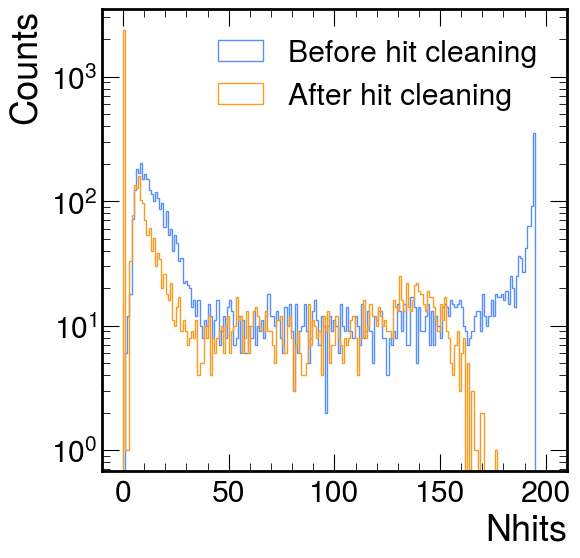

In [ ]:
# raw_nhits = run.get_nhits(hit_masks=None)
# cleaned_nhits = run.get_nhits(hit_masks=['hit_amplitude','hit_charge','hit_time'])

# plt.figure(figsize=(6,6))
# plt.hist(raw_nhits,np.linspace(0,200,200),histtype='step',label='Before hit cleaning')
# plt.hist(cleaned_nhits,np.linspace(0,200,200),histtype='step',label='After hit cleaning')
# plt.yscale('log')
# plt.xlabel('Nhits')
# plt.ylabel('Counts')
# plt.legend()

# tstamp = run.output_data['timestamp']
# print(len(tstamp), len(raw_nhits),len(cleaned_nhits))
# print(f"{len(tstamp)} triggers in {(tstamp[-1]-tstamp[0])*1e-9}")
# print(f"{len(tstamp)/((tstamp[-1]-tstamp[0])*1e-9)}") 

# min_diff_cut = 1e-3 # seconds
# max_diff_cut = 10 # seconds

# cuts = [0, 15, 50, 100, 150] # nhit
# colors = ['black', 'red', 'blue', 'green', 'purple']

# plt.figure(figsize=(6,6))

# bins = np.logspace(np.log10(1e-7), np.log10(1e1), 100)

# for cut, color in zip(cuts, colors):
#     mask = raw_nhits > cut
#     ntstamp = tstamp[mask]
#     if len(ntstamp) < 2:
#         print(f"raw nhits>{cut}: not enough events")
#         continue
#     # Compute diffs (convert ns to seconds if timestamps are in ns)
#     raw_diffs = np.diff(ntstamp) * 1e-9
#     cut_diffs = raw_diffs[(min_diff_cut < raw_diffs) & (raw_diffs < max_diff_cut)]
#     # Compute rate
#     frank = np.cumsum(cut_diffs)
#     if len(frank) < 2:
#         rate = np.nan
#     else:
#         rate = len(frank) / (frank[-1] - frank[0])  # Hz

#     print(f"raw nhits>{cut}: 32*{rate:.2f} Hz [{len(frank):.0f} triggers in {frank[-1]-frank[0]:.2f} s]")
#     # Histogram
#     plt.hist(
#         raw_diffs,
#         bins=bins,
#         histtype='step',
#         density=True,
#         color=color,
#         label=f"raw nhits>{cut} - {32*rate:.2f} Hz"
#     )

# for cut, color in zip(cuts, colors):
#     mask = cleaned_nhits > cut
#     ntstamp = tstamp[mask]
#     if len(ntstamp) < 2:
#         print(f"cleaned nhits>{cut}: not enough events")
#         continue
#     # Compute diffs (convert ns to seconds if timestamps are in ns)
#     cleaned_diffs = np.diff(ntstamp) * 1e-9
#     cut_diffs = cleaned_diffs[(min_diff_cut < cleaned_diffs) & (cleaned_diffs < max_diff_cut)]
#     # Compute rate
#     frank = np.cumsum(cut_diffs)
#     if len(frank) < 2:
#         rate = np.nan
#     else:
#         rate = len(frank) / (frank[-1] - frank[0])  # Hz

#     print(f"cleaned nhits>{cut}: 32*{rate:.2f} Hz [{len(frank):.0f} triggers in {frank[-1]-frank[0]:.2f} s]")
#     # Histogram
#     plt.hist(
#         cleaned_diffs,
#         bins=bins,
#         histtype='step',
#         density=True,
#         color=color,
#         ls='--',
#         label=f"cleaned nhits>{cut} - {32*rate:.2f} Hz"
#     )


# # Formatting
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel("Time between events [s]")
# plt.ylabel("Arb.")
# plt.axvline(max_diff_cut, color='gray', linestyle='--', label='Min/Max Time Cut')
# plt.axvline(min_diff_cut, color='gray', linestyle='--')#, label='Time Cut')
# plt.legend(loc='upper right', fontsize=10)
# # plt.title('Time Between Events')
# # plt.xlim(0,1000)
# plt.tight_layout()
# plt.xticks(np.logspace(np.log10(1e-7), np.log10(1e1), 9))
# plt.show()

In [ ]:
# print(len(np.diff(run.output_data['timestamp'])),len(raw_nhits[1:]))
# x_bins = np.logspace(np.log10(1e-7), np.log10(10), 50)
# y_bins = np.linspace(0,200,50)
# from matplotlib.colors import LogNorm
# plt.figure(figsize=(6,6))
# plt.hist2d(np.array(np.diff(run.output_data['timestamp'])*1e-9),np.array(cleaned_nhits[1:]),bins=[x_bins,y_bins])#,norm=LogNorm());
# plt.xscale('log')
# plt.xlabel('Time Since Last Event')
# plt.ylabel('Cleaned Nhits')
# plt.colorbar()

FieldNotFoundError: no field 'timestamp' in record with 11 fields

This error occurred while attempting to slice

    <Array [{...}, {...}, ..., {...}, {...}] type='5000 * {timeSinceLastTri...'>

with

    'timestamp'

In [ ]:



run.create_energy_masks(high_energy_min=125,low_energy_min=50,hit_masks=['hit_amplitude','hit_charge','hit_time'],high_name='high_energy',low_name='low_energy')
# run.compute_low_energy_delayed_times_new(high_name='high_energy',low_name='low_energy',cutmulti=True,min_time_window_us=0.8,max_time_window_us=20)

fid_cut = [1000,1000] 
fid_cut_loose = [1500,1500]

run.create_fiducial_volume_mask(z_cut=fid_cut[1], r_cut=fid_cut[0], mask_name='snd_fiducial')


<Array [False, False, False, False, ..., False, True, True] type='5000 * bool'>

In [ ]:

run.compute_low_energy_delayed_times(high_name='high_energy',low_name='low_energy',min_time_window_us=0.8,max_time_window_us=20);
# run.compute_low_energy_delayed_times_old(high_name='high_energy',low_name='low_energy')

In [ ]:
# start = 0
# end = 30
# print(len(run.low_energy_dt_new))#,run.low_energy_dt_new[start:end])
# print(len(run.low_energy_dt_newer))#,run.low_energy_dt_newer[start:end])
# print(len(run.low_energy_dt_old))#,run.low_energy_dt_old[start:end])

# t1 = run.low_energy_dt_newer#[run.low_energy_dt_newer >0]
# t2 = run.low_energy_dt_old
# for i in range(max(len(t1),len(t2))):
#     print(f"{t1[i]:.2f},{t2[i]:.2f}")
#     # print(f"{t2[i]:.2f}")

In [ ]:
run.create_low_energy_time_masks(michel_range=(0.8,3),background_range=(15,20),low_energy_mask_name='low_energy',michel_name='michel',background_name='background')
# run.create_low_energy_time_masks(michel_range=(1,3),background_range=(20,400),low_energy_mask_name='low_energy',michel_name='michel_old',background_name='background_old',old=True)


(array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]))

In [ ]:

for name, mask in run.masks.items():
    print(name,len(mask))

hit_amplitude 5000
hit_charge 5000
hit_time 5000
high_energy 5000
low_energy 5000
snd_fiducial 5000
michel 5000
background 5000


In [ ]:

mc.create_hit_amplitude_mask()
mc.create_hit_charge_mask(min_charge=0)
mc.calculate_time_residuals()
mc.create_hit_time_mask(time_range=time_range);


In [ ]:
mc.create_energy_masks(high_energy_min=125,low_energy_min=50,hit_masks=['hit_amplitude','hit_charge','hit_time'],high_name='high_energy',low_name='low_energy')


(<Array [False, False, False, ..., False, False, False] type='1000 * bool'>,
 <Array [True, True, True, True, ..., False, False, True] type='1000 * bool'>)

NameError: name 'mcRef_charges' is not defined

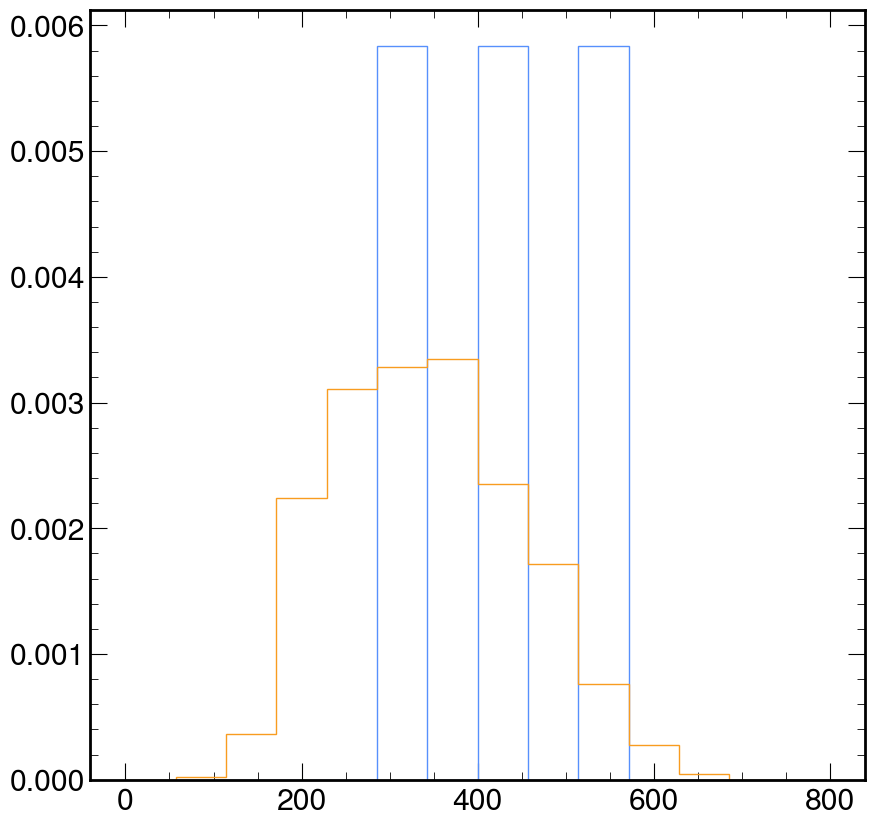

In [ ]:

run_charges = run.get_hit_charges(hit_masks=['hit_charge','hit_amplitude','hit_time'],event_masks=['michel'])
# run_charges_old = run.get_hit_charges(hit_masks=['hit_charge','hit_amplitude','hit_time'],event_masks=['michel_old'])
mc_charges = mc.get_hit_charges(hit_masks=['hit_charge','hit_amplitude','hit_time'],event_masks=['low_energy'])
# mcRef_charges = mcRef.get_hit_charges(hit_masks=['hit_charge','hit_amplitude','hit_time'],event_masks=['low_energy'])

run_background = run.get_hit_charges(hit_masks=['hit_charge','hit_amplitude','hit_time'],event_masks=['background'])

edges = np.linspace(0,800,15)
plt.hist(ak.sum(run_charges,axis=1),edges,histtype='step',label='run new',density=True)
# plt.hist(ak.sum(run_background,axis=1),edges,histtype='step',label='run new',density=True)
# plt.hist(ak.sum(run_charges_old,axis=1),edges,histtype='step',label='run old',density=True)
plt.hist(ak.sum(mc_charges,axis=1),edges,histtype='step',label='mc',density=True)
# plt.hist(ak.sum(mcRef_charges,axis=1),edges,histtype='step',label='mc ref',density=True)
plt.legend()

print(f"{len(run_charges)}")

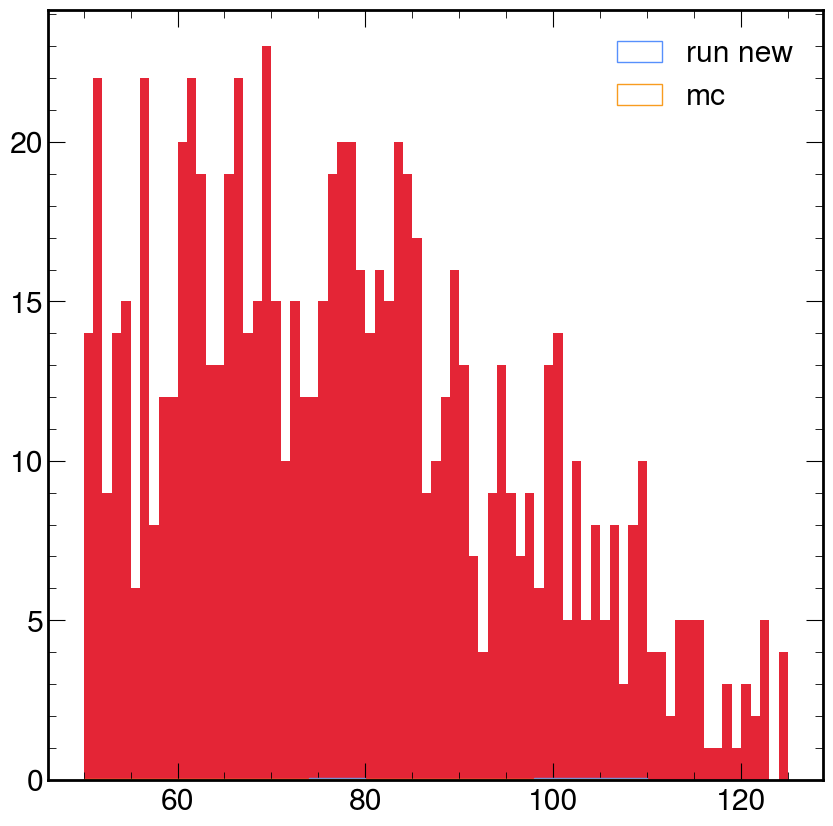

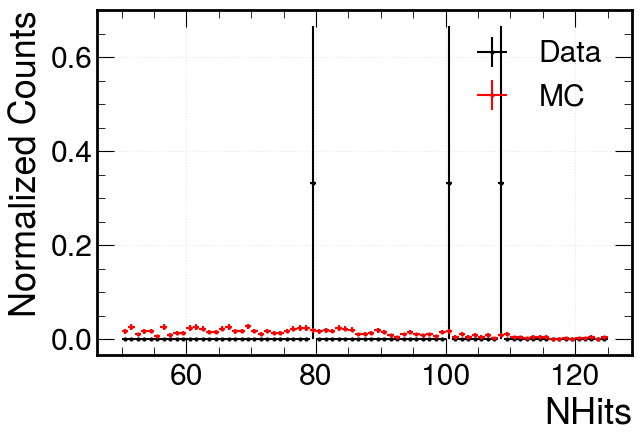

In [ ]:
edges = np.arange(50,125,6)
plt.hist(ak.count(run_charges,axis=1),edges,histtype='step',label='run new',density=True)
# plt.hist(ak.sum(run_background,axis=1),edges,histtype='step',label='run new',density=True)
# plt.hist(ak.count(run_charges_old,axis=1),edges,histtype='step',label='run old',density=True)
plt.hist(ak.count(mc_charges,axis=1),edges,histtype='step',label='mc',density=True)
# plt.hist(ak.count(mcRef_charges,axis=1),edges,histtype='step',label='mc ref',density=True)
plt.legend()

import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

# --- Define bin edges and bin centers ---
edges = np.arange(50, 126,1)
centers = 0.5 * (edges[:-1] + edges[1:])
bin_width = np.diff(edges)
xerr = bin_width / 2

# --- Compute histograms (counts, not densities yet) ---
data_vals = ak.count(run_charges, axis=1)
mc_vals   = ak.count(mc_charges, axis=1)

plt.hist(mc_vals,np.arange(50,126,1))
plt.show

data_counts, _ = np.histogram(data_vals, bins=edges)
mc_counts,   _ = np.histogram(mc_vals,   bins=edges)

# --- Normalize to density if you want ---
data_density = data_counts / np.sum(data_counts) / bin_width
mc_density   = mc_counts   / np.sum(mc_counts)   / bin_width

# --- Compute errors ---
# Poisson (sqrt(N)) on counts → propagate to density
data_yerr = np.sqrt(data_counts) / np.sum(data_counts) / bin_width
mc_yerr   = np.sqrt(mc_counts)   / np.sum(mc_counts)   / bin_width

# --- Plot setup ---
plt.figure(figsize=(7,5))

# Data in black with error bars
plt.errorbar(
    centers, data_density, yerr=data_yerr, xerr=xerr,
    fmt='.', color='black', label='Data', markersize=4, capsize=0
)

# MC in red with line (and optional shaded error band)
plt.errorbar(
    centers, mc_density, yerr=mc_yerr, xerr=xerr,
    fmt='.', color='red', label='MC', markersize=4, capsize=0
)

# --- Style tweaks ---
plt.xlabel('NHits')
plt.ylabel('Normalized Counts')
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


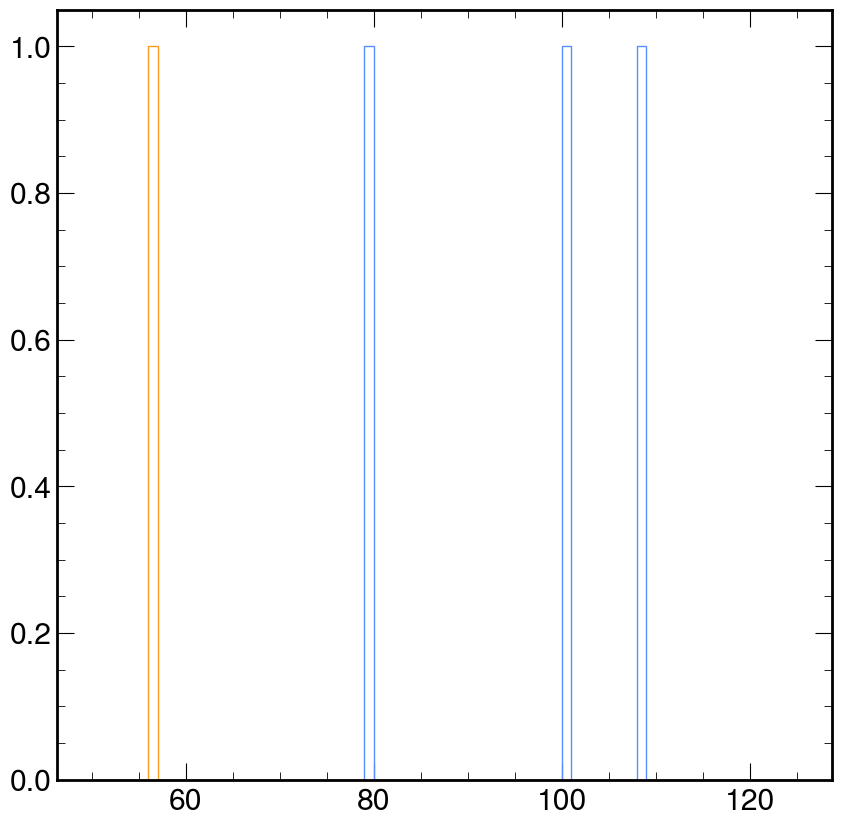

In [ ]:
mnhit = run.get_nhits(hit_masks=['hit_time','hit_charge','hit_amplitude'],event_masks=['michel'])
bnhit = run.get_nhits(hit_masks=['hit_time','hit_charge','hit_amplitude'],event_masks=['background'])

edges = np.arange(50,126,1)
plt.hist(mnhit,edges,histtype='step')
plt.hist(bnhit,edges,histtype='step');

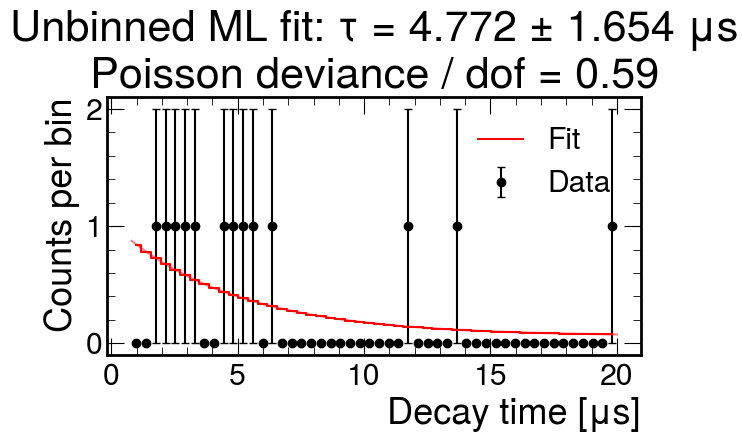

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import xlogy
import matplotlib.pyplot as plt

# ========== MODEL HELPERS ==========

def expected_counts_per_bin(bin_edges, A, tau, B):
    """Integrate A*exp(-t/tau)+B over each bin."""
    t0 = bin_edges[:-1]
    t1 = bin_edges[1:]
    signal = A * tau * (np.exp(-t0 / tau) - np.exp(-t1 / tau))
    background = B * (t1 - t0)
    return signal + background


# ========== UNBINNED EXTENDED LIKELIHOOD ==========

def neg_loglike_unbinned_extended(params, events, tmin, tmax):
    """Negative log-likelihood for unbinned extended model."""
    A, tau, B = params
    if tau <= 0 or A < 0 or B < 0:
        return 1e30
    Nexp = A * tau * (np.exp(-tmin/tau) - np.exp(-tmax/tau)) + B * (tmax - tmin)
    if Nexp <= 0:
        return 1e30
    numer = A * np.exp(-events / tau) + B
    if np.any(numer <= 0):
        return 1e30
    nll = Nexp - np.sum(np.log(numer)) + len(events) * np.log(Nexp)
    return nll

def fit_unbinned_extended(events, tmin, tmax, p0=None, bounds=None):
    """Fit A, tau, B using unbinned extended likelihood."""
    if p0 is None:
        tau0 = max(0.5, np.median(events))
        rate_est = len(events) / (tmax - tmin)
        A0, B0 = rate_est, 0.0
        p0 = [A0, tau0, B0]
    if bounds is None:
        bounds = [(0, None), (1e-6, None), (0, None)]
    res = minimize(
        neg_loglike_unbinned_extended, p0, args=(events, tmin, tmax),
        bounds=bounds, method='L-BFGS-B', options={'maxiter':10000}
    )
    if not res.success:
        print("Warning:", res.message)
    return {'popt':res.x, 'nll':res.fun, 'success':res.success, 'message':res.message, 'res':res}


# ========== BOOTSTRAP FOR ERRORS ==========

def bootstrap_unbinned(events, tmin, tmax, nboot=300):
    """Bootstrap resampling for robust parameter errors."""
    params = []
    n = len(events)
    for _ in range(nboot):
        sample = np.random.choice(events, size=n, replace=True)
        res = fit_unbinned_extended(sample, tmin, tmax)
        if res['success']:
            params.append(res['popt'])
    params = np.array(params)
    if len(params) == 0:
        raise RuntimeError("All bootstrap fits failed.")
    mean = np.mean(params, axis=0)
    std = np.std(params, axis=0, ddof=1)
    return {'params': params, 'mean': mean, 'std': std}


# ========== MAIN FIT + PLOT FUNCTION ==========

def plot_muon_lifetime_unbinned_fit(events, start_time, stop_time, bins=50, nboot=300):
    """Full analysis: fit unbinned, bootstrap, and plot binned display."""
    # 1. Perform fit
    res = fit_unbinned_extended(events, start_time, stop_time)
    A_fit, tau_fit, B_fit = res['popt']

    # 2. Bootstrap errors
    boot = bootstrap_unbinned(events, start_time, stop_time, nboot=nboot)
    A_err, tau_err, B_err = boot['std']

    # 3. Make histogram for visualization
    bin_edges = np.linspace(start_time, stop_time, bins+1)
    counts, _ = np.histogram(events, bins=bin_edges)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # 4. Compute model prediction per bin (integrated)
    expected = expected_counts_per_bin(bin_edges, A_fit, tau_fit, B_fit)
    scale = np.sum(counts) / np.sum(expected)
    expected_scaled = expected * scale

    # 5. Compute Poisson deviance per dof
    mu = expected_scaled
    k = counts
    with np.errstate(divide='ignore', invalid='ignore'):
        D = 2 * np.nansum(xlogy(k, k/mu) - (k - mu))
    ndof = len(k) - 3
    D_red = D / ndof if ndof > 0 else np.nan

    # 6. Plot
    plt.figure(figsize=(7,5))
    plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', color='k',
                 label='Data', capsize=3)
    plt.step(bin_centers, expected_scaled, where='mid', color='red', label='Fit')

    # Smooth curve (optional)
    t_fine = np.linspace(start_time, stop_time, 1000)
    smooth = A_fit * np.exp(-t_fine / tau_fit) + B_fit
    plt.plot(t_fine, smooth * (bin_edges[1]-bin_edges[0]) * scale,
             color='r', alpha=0.5)

    plt.xlabel("Decay time [μs]")
    plt.ylabel("Counts per bin")
    plt.title(f"Unbinned ML fit: τ = {tau_fit:.3f} ± {tau_err:.3f} μs\n"
              f"Poisson deviance / dof = {D_red:.2f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'A': A_fit, 'A_err': A_err,
        'tau': tau_fit, 'tau_err': tau_err,
        'B': B_fit, 'B_err': B_err,
        'deviance': D, 'deviance_red': D_red
    }


# ========== USAGE EXAMPLE ==========
# Assuming you have a numpy array of event times called `deltat`
# and you want to fit between 0.8 μs and 20 μs:

result = plot_muon_lifetime_unbinned_fit(run.low_energy_dt[run.low_energy_dt>0], start_time=0.8, stop_time=20, bins=50)


In [ ]:
hits, err = run.compute_coincident_hits(hit_masks=['hit_time','hit_amplitude','hit_charge'],event_masks=['michel']);


In [37]:
# Define PMT channels
barrel_boards = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
barrel_channels = [16 * board + i for board in barrel_boards for i in range(16)]

special_channels = np.arange(0, 36, 1)

top_boards =  [12, 13]
top_channels = [16 * board + i for board in top_boards for i in range(16)]

dichroic_boards = [7]
dichroic_channels = [16 * board + i for board in dichroic_boards for i in range(16)]

bottom_boards = [14, 15]
bottom_channels = [16 * board + i for board in bottom_boards for i in range(16)]

behind_boards = [16]
behind_channels = [16 * board + i for board in behind_boards for i in range(13)]

<ErrorbarContainer object of 3 artists>

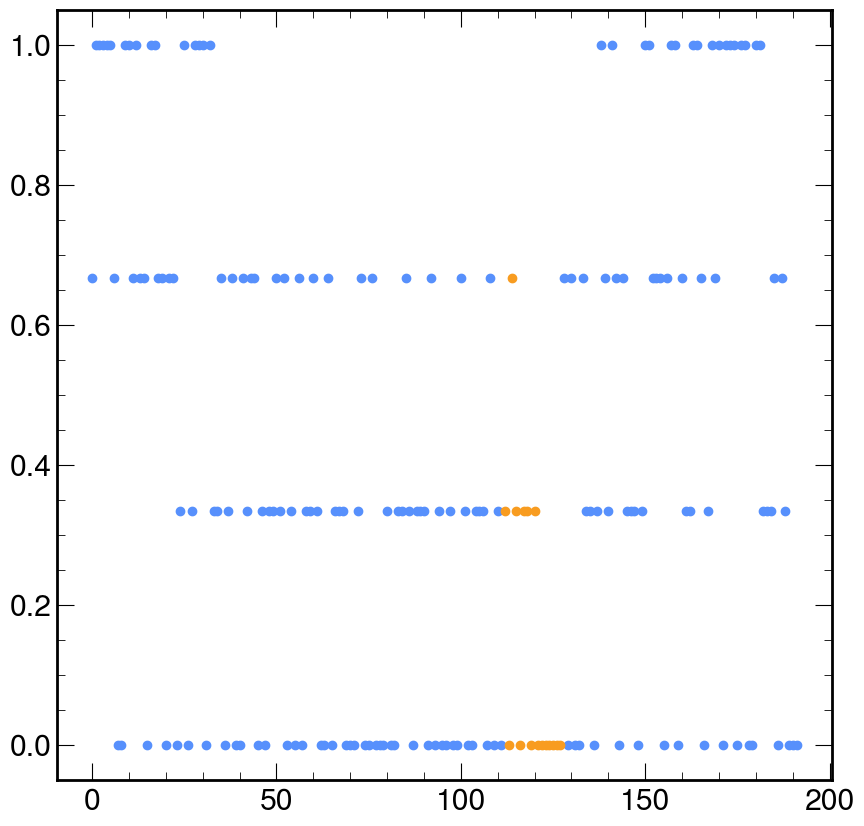

In [38]:
plt.errorbar(barrel_channels,hits[barrel_channels],label='barrel',fmt='o')
plt.errorbar(dichroic_channels,hits[dichroic_channels],label='dichroic',fmt='o')


In [39]:
def compute_coincident_hits(hit_masks=None, event_masks=None, normalize_by_events=True, return_ids=False):
    pmt_ids = run.meta_data['pmtId'][0]
    pmt_chs = run.meta_data['pmtChannel'][0]
    id2ch = dict(zip(pmt_ids, pmt_chs))
    ch2id = dict(zip(pmt_chs, pmt_ids))

    clean_ids = run.output_data['fit_pmtid_Lognormal']

    if hit_masks:
        hit_mask = run.combine_masks(hit_masks, mask_type='hit')
        clean_ids = ak.mask(clean_ids, hit_mask)
    if event_masks:
        event_mask = run.combine_masks(event_masks, mask_type='event')
        clean_ids = clean_ids[event_mask]

    nevents = len(clean_ids)
    flat_clean_ids = ak.to_numpy(ak.flatten(clean_ids))
    
    # Filter out masked or invalid IDs
    valid_ids = [int(id) for id in flat_clean_ids if id is not None and not np.ma.is_masked(id)]
    
    # Map to logical channels
    flat_clean_lcns = np.array([id2ch[id] for id in valid_ids])


    pmt_hit_counts = np.bincount(flat_clean_lcns, minlength=np.max(pmt_chs) + 1)
    pmt_hit_err = np.sqrt(pmt_hit_counts)

    if normalize_by_events and nevents > 0:
        pmt_hit_counts = pmt_hit_counts / nevents
        pmt_hit_err = pmt_hit_err / nevents

    # Active PMTs
    active_lcns = np.nonzero(pmt_hit_counts)[0]
    active_ids = [ch2id[lcn] for lcn in active_lcns if lcn in ch2id]

    if return_ids:
        return pmt_hit_counts, pmt_hit_err, active_ids
    else:
        return pmt_hit_counts, pmt_hit_err


In [40]:


# --- Define PMT channel groups ---
barrel_boards = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
barrel_channels = [16 * b + i for b in barrel_boards for i in range(16)]
special_channels = np.arange(0, 36)
top_boards = [12, 13]
top_channels = [16 * b + i for b in top_boards for i in range(16)]
dichroic_boards = [7]
dichroic_channels = [16 * b + i for b in dichroic_boards for i in range(16)]
bottom_boards = [14, 15]
bottom_channels = [16 * b + i for b in bottom_boards for i in range(16)]
behind_boards = [16]
behind_channels = [16 * b + i for b in behind_boards for i in range(13)]

groups = {
    "dichroic": dichroic_channels,
    # "barrel": barrel_channels,
    # "top": top_channels,
    # "bottom": bottom_channels,
    # "behind": behind_channels,
    # "special": special_channels,
}


In [41]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

def dichroic_avg_vs_z(run, event_mask_name, dichroic_channels,
                      binwidth=50, zrange=(-1200, 1200),
                      hit_masks=['hit_time','hit_amplitude','hit_charge'],
                      normalize_by_events=True, plot=False):

    # --- Setup ---
    pmt_ids = run.meta_data['pmtId'][0]
    pmt_chs = run.meta_data['pmtChannel'][0]
    id2ch = dict(zip(pmt_ids, pmt_chs))
    ch2id = dict(zip(pmt_chs, pmt_ids))
    
    recoz = run.output_data['z_seedndestroy']
    zedges = np.arange(zrange[0], zrange[1] + binwidth, binwidth)
    zcenters = 0.5 * (zedges[:-1] + zedges[1:])
    xerr = np.full_like(zcenters, binwidth / 2, dtype=float)

    # --- Base hit and event masks ---
    clean_ids = run.output_data['fit_pmtid_Lognormal']
    if hit_masks:
        hit_mask = run.combine_masks(hit_masks, mask_type='hit')
        clean_ids = ak.mask(clean_ids, hit_mask)
    base_event_mask = run.combine_masks([event_mask_name], mask_type='event')

    # --- Outputs ---
    avg_per_z = []
    err_per_z = []
    nevents_per_z = []
    total_hits_per_z = []

    for zmin, zmax in zip(zedges[:-1], zedges[1:]):
        zmask = (recoz > zmin) & (recoz <= zmax)
        combined_event_mask = base_event_mask & zmask
        
        # Apply event mask
        event_ids = clean_ids[combined_event_mask]
        nevents = len(event_ids)
        nevents_per_z.append(nevents)
        
        if nevents == 0:
            avg_per_z.append(np.nan)
            err_per_z.append(np.nan)
            total_hits_per_z.append(0)
            continue

        flat_ids = ak.to_numpy(ak.flatten(event_ids))
        valid_ids = [int(i) for i in flat_ids if i is not None and not np.ma.is_masked(i)]
        flat_lcns = np.array([id2ch[i] for i in valid_ids])

        # Count only dichroic channels
        dichroic_hits = np.sum(np.isin(flat_lcns, dichroic_channels))
        total_hits_per_z.append(dichroic_hits)

        # Normalize per event and compute uncertainty
        if normalize_by_events:
            avg_hits = dichroic_hits / nevents
            err_hits = np.sqrt(dichroic_hits) / nevents  # standard error of mean
        else:
            avg_hits = dichroic_hits
            err_hits = np.sqrt(dichroic_hits)

        avg_per_z.append(avg_hits)
        err_per_z.append(err_hits)

    avg_per_z = np.array(avg_per_z)
    err_per_z = np.array(err_per_z)
    nevents_per_z = np.array(nevents_per_z)
    total_hits_per_z = np.array(total_hits_per_z)

    # --- Optional plot ---
    if plot:
        plt.figure(figsize=(8, 6))
        plt.errorbar(
            zcenters, avg_per_z, yerr=err_per_z, xerr=xerr,
            fmt='.', color='black', markersize=4, capsize=0,
            label=f"{event_mask_name} events"
        )
        plt.xlabel("Reconstructed Z [mm]")
        plt.ylabel("Average Dichroic Hits per Event")
        plt.legend(frameon=False)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return zcenters, avg_per_z, err_per_z, nevents_per_z, total_hits_per_z


In [42]:
bin_width=50

# Data
zcenters_data, avg_per_z_data , err_per_z_data, nevents_per_z_data, total_hits_per_z_data = dichroic_avg_vs_z(
    run,
    event_mask_name='michel',
    dichroic_channels=dichroic_channels,
    binwidth=bin_width
)

# MC
zcenters_mc, avg_per_z_mc, err_per_z_mc, nevents_per_z_mc, total_hits_per_z_mc = dichroic_avg_vs_z(
    mc,
    event_mask_name='low_energy',
    dichroic_channels=dichroic_channels,
    binwidth=bin_width
)


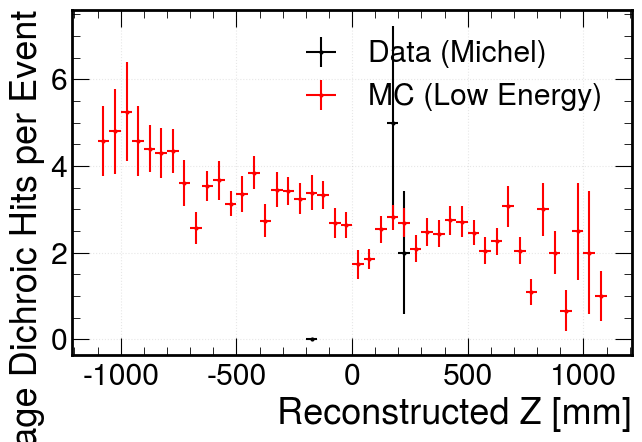

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---

# --- Compute errors ---
xerr_data = np.full_like(zcenters_data, bin_width/2, dtype=float)
xerr_mc   = np.full_like(zcenters_mc,   bin_width/2, dtype=float)

# --- ot ---
plt.figure(figsize=(7,5))

# Data (Michel)
plt.errorbar(
    zcenters_data, avg_per_z_data,
    yerr=err_per_z_data, xerr=xerr_data,
    fmt='.', color='black', label='Data (Michel)',
    markersize=4, capsize=0
)

# MC (Low Energy)
plt.errorbar(
    zcenters_mc, avg_per_z_mc,
    yerr=err_per_z_mc, xerr=xerr_mc,
    fmt='.', color='red', label='MC (Low Energy)',
    markersize=4, capsize=0
)

# --- Style ---
plt.xlabel("Reconstructed Z [mm]")
plt.ylabel("Average Dichroic Hits per Event")
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [ ]:

# # ============================================================================
# # CONFIGURATION SETUP
# # ============================================================================

# analyses = {
#     'run': run,
#     'mc': mc,
#     'mcRef': mcRef
# }

# reco_configs = {
#     'snd_log': {'use_snd': True, 'use_lognormal': True},
#     'quad_log': {'use_snd': False, 'use_lognormal': True},
#     'snd_digit': {'use_snd': True, 'use_lognormal': False},
#     'quad_digit': {'use_snd': False, 'use_lognormal': False},
# }

# hit_configs = {
#     'tight': {'time_range': (-2, 2)},
#     'weird': {'time_range': (-8,3)},
#     'loose': {'time_range': (-10, 10)},
# }

# energy_configs = {
#     'ben': {'high': 125, 'low': 50},
#     #'tanner': {'high': 160, 'low': 80}
# }

# lookup_variations = [
#     # {'suffix': '', 'fid_name': None, 'cutmulti': True, 'max_time': 20, 'bg_range': (15, 20)},
#     {'suffix': '_long', 'fid_name': None, 'cutmulti': True, 'max_time': 400, 'bg_range': (20, 400)},
# ]

# min_charge = 0

# # ============================================================================
# # STEP 1-4: CREATE ALL MASKS (same as before)
# # ============================================================================

# # Calculate time residuals, create hit masks, fiducial masks, energy masks
# # (code from previous version)

# for name, analysis in analyses.items():
#     print(f"\nProcessing {name}...")
    
#     if not hasattr(analysis, 'time_residuals_cache'):
#         analysis.time_residuals_cache = {}
    
#     analysis.create_hit_amplitude_mask()
#     analysis.create_hit_charge_mask(min_charge=min_charge)
    
#     for reco_name, reco_config in reco_configs.items():
#         analysis.calculate_time_residuals(**reco_config)
#         analysis.time_residuals_cache[reco_name] = ak.copy(analysis.hit_time_res)
        
#         for hit_type, hit_config in hit_configs.items():
#             mask_name = f"{hit_type}_hit_time_{reco_name}"
#             analysis.create_hit_time_mask(
#                 time_range=hit_config['time_range'],
#                 mask_name=mask_name
#             )
        
#         analysis.create_fiducial_volume_mask(
#             z_cut=600, r_cut=600,
#             use_snd=reco_config['use_snd'],
#             mask_name=f"{reco_name}_fiducial"
#         )
    
#     for energy_name, energy_config in energy_configs.items():
#         for reco_name in reco_configs.keys():
#             for hit_type in hit_configs.keys():
#                 hit_cleaning_masks = [
#                     'hit_amplitude',
#                     'hit_charge',
#                     f"{hit_type}_hit_time_{reco_name}"
#                 ]
                
#                 analysis.create_energy_masks(
#                     high_energy_min=energy_config['high'],
#                     low_energy_min=energy_config['low'],
#                     hit_masks=hit_cleaning_masks,
#                     high_name=f"{energy_name}_high_{reco_name}_{hit_type}",
#                     low_name=f"{energy_name}_low_{reco_name}_{hit_type}"
#                 )


In [293]:

# # ============================================================================
# # STEP 5: RUN FORWARD LOOKUP ONLY FOR RUN DATA
# # ============================================================================

# print("\n" + "="*60)
# print("RUNNING FORWARD LOOKUPS (RUN DATA ONLY)")
# print("="*60)

# fit_results = {}

# for reco_name in reco_configs.keys():
#     for energy_name in energy_configs.keys():
#         for hit_type in hit_configs.keys():
#             for var in lookup_variations:
                
#                 config_name = f"{energy_name}_{reco_name}_{hit_type}{var['suffix']}"
                
#                 print(f"\nRunning: {config_name}")
                
#                 fid_name = f"{reco_name}_fiducial" if var['fid_name'] else None
                
#                 try:
#                     # # ONLY run on 'run', not mc/mcRef
#                     # dt_masks = run.compute_low_energy_delayed_times(
#                     #     low_name=f"{energy_name}_low_{reco_name}_{hit_type}",
#                     #     high_name=f"{energy_name}_high_{reco_name}_{hit_type}",
#                     #     fid_name=fid_name,
#                     #     cutmulti=var['cutmulti'],
#                     #     min_time_window_us=1,
#                     #     max_time_window_us=var['max_time']
#                     # )
#                     dt_masks = run.compute_low_energy_delayed_times_old(
#                         low_name=f"{energy_name}_low_{reco_name}_{hit_type}",
#                         high_name=f"{energy_name}_high_{reco_name}_{hit_type}"
#                     )
#                     print("made dt")
                    
#                     fit_results[config_name] = fit_muon_lifetime(run)
#                     print("fit")
#                     run.create_low_energy_time_masks(
#                         michel_range=(1, 5),
#                         background_range=var['bg_range'],
#                         low_energy_mask_name=f"{energy_name}_low_{reco_name}_{hit_type}",
#                         michel_name=f"{energy_name}_michel_{reco_name}_{hit_type}{var['suffix']}",
#                         background_name=f"{energy_name}_background_{reco_name}_{hit_type}{var['suffix']}",old=True
#                     )
#                     print("michel")
                    
#                 except Exception as e:
#                     print(f"ERROR: {e}")
#                     fit_results[config_name] = {'success': False, 'error': str(e)}


In [294]:

# # ============================================================================
# # STEP 6: CREATE CHARGE COMPARISON PLOTS
# # ============================================================================

# print("\n" + "="*60)
# print("CREATING CHARGE COMPARISON PLOTS")
# print("="*60)

# def plot_charge_comparison(run, mc, mcRef, config_name, hit_masks, event_masks):
#     """
#     Plot hit charge, total charge, and nhit comparison between run, mc, mcRef
#     """
#     # Get charges for each analysis
#     run_charges = run.get_hit_charges(hit_masks=hit_masks, event_masks=event_masks)
#     mc_charges = mc.get_hit_charges(hit_masks=hit_masks, event_masks=event_masks)
#     mcRef_charges = mcRef.get_hit_charges(hit_masks=hit_masks, event_masks=event_masks)
    
#     # Binning
#     hc_bins = np.linspace(-10, 10, 50)
#     tc_bins = np.linspace(0, 2000, 50)
#     n_bins = np.linspace(0, 200, 200)
    
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
#     # Hit charge
#     axes[0].hist(ak.flatten(run_charges), hc_bins, histtype='step', 
#                 label='Run Data', color='black', linewidth=2)
#     axes[0].hist(ak.flatten(mc_charges), hc_bins, histtype='step',
#                 label='MC', color='blue', linewidth=2)
#     axes[0].hist(ak.flatten(mcRef_charges), hc_bins, histtype='step',
#                 label='MC Ref', color='red', linewidth=2)
#     axes[0].set_xlabel('Hit Charge [pC]')
#     axes[0].set_ylabel('Counts')
#     axes[0].set_yscale('log')
#     axes[0].legend()
#     axes[0].set_title('Hit Charge Distribution')
#     axes[0].grid(True, alpha=0.3)
    
#     # Total charge
#     axes[1].hist(ak.sum(run_charges, axis=1), tc_bins, histtype='step',
#                 label='Run Data', color='black', linewidth=2)
#     axes[1].hist(ak.sum(mc_charges, axis=1), tc_bins, histtype='step',
#                 label='MC', color='blue', linewidth=2)
#     axes[1].hist(ak.sum(mcRef_charges, axis=1), tc_bins, histtype='step',
#                 label='MC Ref', color='red', linewidth=2)
#     axes[1].set_xlabel('Total Charge per Event [pC]')
#     axes[1].set_ylabel('Counts')
#     axes[1].set_yscale('log')
#     axes[1].legend()
#     axes[1].set_title('Total Charge Distribution')
#     axes[1].grid(True, alpha=0.3)
    
#     # NHits
#     axes[2].hist(ak.count(run_charges, axis=1), n_bins, histtype='step',
#                 label='Run Data', color='black', linewidth=2)
#     axes[2].hist(ak.count(mc_charges, axis=1), n_bins, histtype='step',
#                 label='MC', color='blue', linewidth=2)
#     axes[2].hist(ak.count(mcRef_charges, axis=1), n_bins, histtype='step',
#                 label='MC Ref', color='red', linewidth=2)
#     axes[2].set_xlabel('NHits per Event')
#     axes[2].set_ylabel('Counts')
#     axes[2].set_yscale('log')
#     axes[2].legend()
#     axes[2].set_title('NHits Distribution')
#     axes[2].grid(True, alpha=0.3)
    
#     plt.suptitle(f'Data-MC Comparison: {config_name}', fontsize=14, y=1.02)
#     plt.tight_layout()
#     plt.show()

# # Plot for each configuration
# for reco_name in reco_configs.keys():
#     for energy_name in energy_configs.keys():
#         for hit_type in hit_configs.keys():
            
#             config_base = f"{energy_name}_{reco_name}_{hit_type}"
            
#             # Build hit and event mask lists
#             hit_masks = ['hit_amplitude', 'hit_charge', f'{hit_type}_hit_time_{reco_name}']
#             low_energy_mask = f"{energy_name}_low_{reco_name}_{hit_type}"
            
#             # # Plot 1: Just hit cleaning
#             # print(f"\nPlotting {config_base} - hit cleaning only")
#             # plot_charge_comparison(
#             #     run, mc, mcRef,
#             #     f"{config_base} (hit cleaning)",
#             #     hit_masks=hit_masks,
#             #     event_masks=None
#             # )
            
#             # # Plot 2: Hit cleaning + low energy selection
#             # print(f"Plotting {config_base} - low energy events")
#             # plot_charge_comparison(
#             #     run, mc, mcRef,
#             #     f"{config_base} (low energy)",
#             #     hit_masks=hit_masks,
#             #     event_masks=[low_energy_mask]
#             # )
            
#             # Plot 3: Hit cleaning + Michel selection (RUN DATA ONLY - no Michel mask for MC)
#             michel_mask = f"{energy_name}_michel_{reco_name}_{hit_type}"
#             if michel_mask in run.masks:
#                 print(f"Plotting {config_base} - Michel events (run data only)")
                
#                 fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                
#                 run_michel = run.get_hit_charges(hit_masks=hit_masks, 
#                                                 event_masks=[michel_mask])
#                 mc_low = mc.get_hit_charges(hit_masks=hit_masks,
#                                            event_masks=[low_energy_mask])
#                 mcRef_low = mcRef.get_hit_charges(hit_masks=hit_masks,
#                                                  event_masks=[low_energy_mask])
                
#                 hc_bins = np.linspace(-10, 10, 50)
#                 tc_bins = np.linspace(0, 2000, 50)
#                 n_bins = np.linspace(0, 200, 200)
                
#                 # Hit charge
#                 axes[0].hist(ak.flatten(run_michel), hc_bins, histtype='step',
#                            label='Run Michel', color='black', linewidth=2)
#                 axes[0].hist(ak.flatten(mc_low), hc_bins, histtype='step',
#                            label='MC Low Energy', color='blue', linewidth=2, alpha=0.7)
#                 axes[0].hist(ak.flatten(mcRef_low), hc_bins, histtype='step',
#                            label='MC Ref Low Energy', color='red', linewidth=2, alpha=0.7)
#                 axes[0].set_xlabel('Hit Charge [pC]')
#                 axes[0].set_yscale('log')
#                 axes[0].legend(fontsize=12)
#                 axes[0].grid(True, alpha=0.3)
                
#                 # Total charge
#                 axes[1].hist(ak.sum(run_michel, axis=1), tc_bins, histtype='step',
#                            label='Run Michel', color='black', linewidth=2)
#                 axes[1].hist(ak.sum(mc_low, axis=1), tc_bins, histtype='step',
#                            label='MC Low Energy', color='blue', linewidth=2, alpha=0.7)
#                 axes[1].hist(ak.sum(mcRef_low, axis=1), tc_bins, histtype='step',
#                            label='MC Ref Low Energy', color='red', linewidth=2, alpha=0.7)
#                 axes[1].set_xlabel('Total Charge [pC]')
#                 axes[1].set_yscale('log')
#                 axes[1].legend(fontsize=12)
#                 axes[1].grid(True, alpha=0.3)
                
#                 # NHits
#                 axes[2].hist(ak.count(run_michel, axis=1), n_bins, histtype='step',
#                            label='Run Michel', color='black', linewidth=2)
#                 axes[2].hist(ak.count(mc_low, axis=1), n_bins, histtype='step',
#                            label='MC Low Energy', color='blue', linewidth=2, alpha=0.7)
#                 axes[2].hist(ak.count(mcRef_low, axis=1), n_bins, histtype='step',
#                            label='MC Ref Low Energy', color='red', linewidth=2, alpha=0.7)
#                 axes[2].set_xlabel('NHits')
#                 axes[2].set_yscale('log')
#                 axes[2].legend(fontsize=12)
#                 axes[2].grid(True, alpha=0.3)
                
#                 plt.suptitle(f'Michel vs MC Comparison: {config_base}', fontsize=14)
#                 plt.tight_layout()
#                 plt.show()

# print("\n" + "="*60)
# print("ANALYSIS COMPLETE")
# print("="*60)




hit_amplitude 500057
hit_charge 500057
hit_time 500057


In [ ]:
# charges = run.output_data['digitCharge']

# # Combine all hit masks at once
# combined_mask = run.masks['hit_amplitude'] & run.masks['hit_time'] & run.masks['hit_charge']
# masked_charges = ak.mask(charges, combined_mask)

# # Drop events that have no valid hits (like in Run)
# valid_event_mask = ak.num(masked_charges, axis=1) > 0
# masked_charges = masked_charges[valid_event_mask]


# test_charges = run.get_hit_charges(hit_masks=None,event_masks=None)
# test_charges1 = run.get_hit_charges(hit_masks=['hit_amplitude'],event_masks=None)
# test_charges2 = run.get_hit_charges(hit_masks=['hit_charge'],event_masks=None)
# test_charges3 = run.get_hit_charges(hit_masks=['hit_time'],event_masks=None)
# test_charges4 = run.get_hit_charges(hit_masks=['hit_amplitude','hit_charge','hit_time'],event_masks=None)


# hcbinning = np.linspace(-10,10,50)
# tcbinning = np.linspace(0,2000,50)
# nbinning = np.linspace(0,200,200)

# fig,ax=plt.subplots(1,3,figsize=(20,5))
# ax[0].hist(ak.flatten(test_charges),hcbinning,histtype='step',label='raw')
# ax[0].hist(ak.flatten(test_charges1),hcbinning,histtype='step',label='1');
# ax[0].hist(ak.flatten(test_charges2),hcbinning,histtype='step',label='2');
# ax[0].hist(ak.flatten(test_charges3),hcbinning,histtype='step',label='3');
# ax[0].hist(ak.flatten(test_charges4),hcbinning,histtype='step',label='4');
# ax[0].hist(ak.flatten(masked_charges),hcbinning,histtype='step',label='m');

# ax[0].legend(fontsize=8)
# ax[0].set_yscale('log')

# ax[1].hist(ak.sum(test_charges,axis=1),tcbinning,histtype='step',label='raw')
# ax[1].hist(ak.sum(test_charges1,axis=1),tcbinning,histtype='step',label='1');
# ax[1].hist(ak.sum(test_charges2,axis=1),tcbinning,histtype='step',label='2');
# ax[1].hist(ak.sum(test_charges3,axis=1),tcbinning,histtype='step',label='3');
# ax[1].hist(ak.sum(test_charges4,axis=1),tcbinning,histtype='step',label='4');
# ax[1].hist(ak.sum(masked_charges,axis=1),tcbinning,histtype='step',label='m');

# ax[1].legend(fontsize=8)
# ax[1].set_yscale('log')

# ax[2].hist(ak.count(test_charges,axis=1),nbinning,histtype='step',label='raw')
# ax[2].hist(ak.count(test_charges1,axis=1),nbinning,histtype='step',label='1');
# ax[2].hist(ak.count(test_charges2,axis=1),nbinning,histtype='step',label='2');
# ax[2].hist(ak.count(test_charges3,axis=1),nbinning,histtype='step',label='3');
# ax[2].hist(ak.count(test_charges4,axis=1),nbinning,histtype='step',label='4');
# ax[2].hist(ak.count(masked_charges,axis=1),nbinning,histtype='step',label='m');

# ax[2].legend(fontsize=8)
# ax[2].set_yscale('log')


=== Simple Forward Lookup ===
High energy candidates: 54362
Low energy candidates: 58202
Accepted pairs (1 low, 0 highs in window following a high): 5944
Cut multiple: True


5944 [260.096  26.848 185.6   312.288  74.176  61.536 232.784  31.92  189.52
 310.928 385.28  234.512  21.376 168.848  83.856 358.208 379.984 127.52
 259.6   378.224  83.248 209.088 130.608 127.664 206.16  101.248 394.656
 395.552  26.016 333.008]
1 [260.096]
58202 [2.60096000e+02 1.71068480e+04 1.72961600e+04 3.92690720e+04
 6.45833440e+04 8.46687200e+04 1.02797040e+05 1.62585040e+05
 1.73241920e+04 4.48092160e+04 6.09296960e+04 5.13975040e+04
 6.33660640e+04 6.36456960e+04 1.72553600e+04 3.95672480e+04
 2.82122080e+04 2.85891040e+04 5.08086560e+04 1.14426912e+05
 1.32310752e+05 2.68480000e+01 1.61104160e+04 1.85600000e+02
 1.00947200e+05 1.67029760e+04 1.68221440e+04 1.63700320e+04
 1.84283040e+04 6.30533440e+04]


(array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]))

In [244]:
print(len(run.low_energy_dt_old),run.low_energy_dt_old[:5])
print(len(run.low_energy_dt_new),run.low_energy_dt_new[:5])
print(len(run.low_energy_dt_newer),run.low_energy_dt_newer[:5])


58202 [  260.096 17106.848 17296.16  39269.072 64583.344]
5944 [260.096  26.848 185.6   312.288  74.176]
1 [260.096]


(array([224., 207., 149., 123., 118.,  79.,  60.,  52.,  53.,  33.,  36.,
         19.,  14.,  14.,  18.,  15.,  17.,   8.,  13.,  12.,   8.,   7.,
         10.,  11.,  10.,   5.,   3.,   8.,   8.,   9.,  11.,   6.,  11.,
          8.,   5.,  10.,   9.,   6.]),
 array([ 0.8,  1.3,  1.8,  2.3,  2.8,  3.3,  3.8,  4.3,  4.8,  5.3,  5.8,
         6.3,  6.8,  7.3,  7.8,  8.3,  8.8,  9.3,  9.8, 10.3, 10.8, 11.3,
        11.8, 12.3, 12.8, 13.3, 13.8, 14.3, 14.8, 15.3, 15.8, 16.3, 16.8,
        17.3, 17.8, 18.3, 18.8, 19.3, 19.8]),
 [<matplotlib.patches.Polygon at 0x7c5827222c10>])

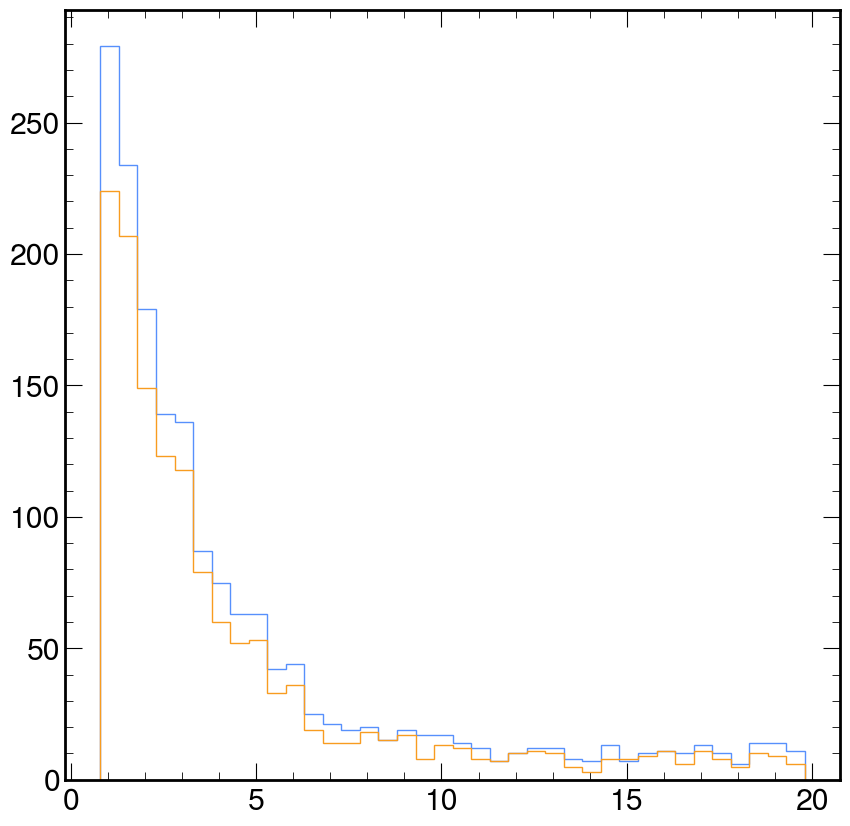

In [ ]:
edges = np.arange(0.8,20,0.5)
plt.hist(run.low_energy_dt_old,edges,histtype='step')
plt.hist(run.low_energy_dt_new,edges,histtype='step')
plt.hist(run.low_energy_dt_newer,edges,histtype='step')

In [226]:
print(ak.count(ak.where(run.masks['michel'])))
print(ak.count(ak.where(run.masks['michel_old'])))

0
1103


In [227]:
# # Calculate time residuals with digitTime and quadfitter
# run.calculate_time_residuals(use_lognormal=False, use_snd=False)
# mc.calculate_time_residuals(use_lognormal=False, use_snd=False)
# mcRef.calculate_time_residuals(use_lognormal=False, use_snd=False)

# run_digit_quad_tres = run.hit_time_res
# mc_digit_quad_tres = mc.hit_time_res
# mcRef_digit_quad_tres = mcRef.hit_time_res

# # Calculate time residuals with digitTime and seedndestroy 
# run.calculate_time_residuals(use_lognormal=False, use_snd=True)
# mc.calculate_time_residuals(use_lognormal=False, use_snd=True)
# mcRef.calculate_time_residuals(use_lognormal=False, use_snd=True)

# run_digit_snd_tres = run.hit_time_res
# mc_digit_snd_tres = mc.hit_time_res
# mcRef_digit_snd_tres = mcRef.hit_time_res

# # Calculate time residuals with lognormal fit and quadfitter
# run.calculate_time_residuals(use_lognormal=True, use_snd=False)
# mc.calculate_time_residuals(use_lognormal=True, use_snd=False)
# mcRef.calculate_time_residuals(use_lognormal=True, use_snd=False)

# run_log_quad_tres = run.hit_time_res
# mc_log_quad_tres = mc.hit_time_res
# mcRef_log_quad_tres = mcRef.hit_time_res

# Calculate time residuals with lognormal fit and seedndestroy (do this last so it overwrites) 
run.calculate_time_residuals(use_lognormal=True, use_snd=True)
mc.calculate_time_residuals(use_lognormal=True, use_snd=True)
mcRef.calculate_time_residuals(use_lognormal=True, use_snd=True)

run_log_snd_tres = run.hit_time_res
mc_log_snd_tres = mc.hit_time_res
mcRef_log_snd_tres = mcRef.hit_time_res

In [228]:
# fig,ax = plt.subplots(1,3,figsize=(15,5))
# binning = np.linspace(-10,10,100)
# ax[0].hist(ak.flatten(run_digit_quad_tres),binning,histtype='step',label='digit + quad')
# ax[0].hist(ak.flatten(run_digit_snd_tres),binning,histtype='step',label='digit + snd')
# ax[0].hist(ak.flatten(run_log_quad_tres),binning,histtype='step',label='log + quad')
# ax[0].hist(ak.flatten(run_log_snd_tres),binning,histtype='step',label='log + snd')
# ax[0].set_title('Run 3056')
# ax[0].set_xlabel('Time Residual (No hit cleaning) [ns]', fontsize=14)
# ax[0].legend(loc='lower center',fontsize=14)
# ax[0].semilogy()

# ax[1].hist(ak.flatten(mc_digit_quad_tres),binning,histtype='step',label='digit + quad')
# ax[1].hist(ak.flatten(mc_digit_snd_tres),binning,histtype='step',label='digit + snd')
# ax[1].hist(ak.flatten(mc_log_quad_tres),binning,histtype='step',label='log + quad')
# ax[1].hist(ak.flatten(mc_log_snd_tres),binning,histtype='step',label='log + snd')
# ax[1].set_title('MC 3056')
# ax[1].set_xlabel('Time Residual (No hit cleaning) [ns]',fontsize=14)
# ax[1].legend(loc='lower center',fontsize=14)
# ax[1].semilogy()

# ax[2].hist(ak.flatten(mcRef_digit_quad_tres),binning,histtype='step',label='digit + quad')
# ax[2].hist(ak.flatten(mcRef_digit_snd_tres),binning,histtype='step',label='digit + snd')
# ax[2].hist(ak.flatten(mcRef_log_quad_tres),binning,histtype='step',label='log + quad')
# ax[2].hist(ak.flatten(mcRef_log_snd_tres),binning,histtype='step',label='log + snd')
# ax[2].set_title('MC Reflections 3056')
# ax[2].set_xlabel('Time Residual (No Hit Cleaning) [ns]', fontsize=14)
# ax[2].legend(loc='lower center',fontsize=14)
# ax[2].semilogy()
# plt.tight_layout()


In [229]:
min_charge = 0
tight_hit_time_range = (-2,2)
loose_hit_time_range = (-10,10)

# Create hit cleaning masks
run.create_hit_amplitude_mask() 
run.create_hit_charge_mask(min_charge=min_charge)  
run.create_hit_time_mask(time_range=tight_hit_time_range,mask_name='tight_hit_time')  
run.create_hit_time_mask(time_range=loose_hit_time_range,mask_name='loose_hit_time')  

mc.create_hit_amplitude_mask() 
mc.create_hit_charge_mask(min_charge=min_charge)  
mc.create_hit_time_mask(time_range=tight_hit_time_range,mask_name='tight_hit_time')  
mc.create_hit_time_mask(time_range=loose_hit_time_range,mask_name='loose_hit_time')  

mcRef.create_hit_amplitude_mask()
mcRef.create_hit_charge_mask(min_charge=min_charge)  
mcRef.create_hit_time_mask(time_range=tight_hit_time_range,mask_name='tight_hit_time')  
mcRef.create_hit_time_mask(time_range=loose_hit_time_range,mask_name='loose_hit_time');

In [230]:
# Hit cleaning masks 
hit_cleaning_masks_loose = ['hit_amplitude', 'hit_charge', 'loose_hit_time']
hit_cleaning_masks_tight = ['hit_amplitude', 'hit_charge', 'tight_hit_time']

# hit_cleaning_masks =  ['hit_time']
# hit_cleaning_masks_loose = ['loose_hit_time']
# hit_cleaning_masks_tight = ['tight_hit_time']

ben_nhit_thresholds = [125,50]
tanner_nhit_thresholds = [160,80]

In [231]:
#Calculate nhits to divide events by energy (various hit time cuts and nhit threshold cuts)
# run.create_energy_masks(high_energy_min=ben_nhit_thresholds[0], low_energy_min=ben_nhit_thresholds[1], hit_masks=hit_cleaning_masks_tight,high_name='ben_high_energy_tight',low_name='ben_low_energy_tight')
# run.create_energy_masks(high_energy_min=ben_nhit_thresholds[0], low_energy_min=ben_nhit_thresholds[1], hit_masks=hit_cleaning_masks,high_name='ben_high_energy',low_name='ben_low_energy')
# run.create_energy_masks(high_energy_min=ben_nhit_thresholds[0], low_energy_min=ben_nhit_thresholds[1], hit_masks=None,high_name='ben_high_energy_loose',low_name='ben_low_energy_loose')
# run.create_energy_masks(high_energy_min=tanner_nhit_thresholds[0], low_energy_min=tanner_nhit_thresholds[1], hit_masks=hit_cleaning_masks_tight,high_name='tanner_high_energy_tight',low_name='tanner_low_energy_tight')
# run.create_energy_masks(high_energy_min=tanner_nhit_thresholds[0], low_energy_min=tanner_nhit_thresholds[1], hit_masks=hit_cleaning_masks,high_name='tanner_high_energy',low_name='tanner_low_energy')
# run.create_energy_masks(high_energy_min=ben_nhit_thresholds[0], low_energy_min=ben_nhit_thresholds[1], hit_masks=None,high_name='ben_high_energy_raw',low_name='ben_low_energy_raw')
run.create_energy_masks(high_energy_min=ben_nhit_thresholds[0], low_energy_min=ben_nhit_thresholds[1], hit_masks=hit_cleaning_masks_tight,high_name='ben_high_energy_clean_tight',low_name='ben_low_energy_clean_tight')
run.create_energy_masks(high_energy_min=ben_nhit_thresholds[0], low_energy_min=ben_nhit_thresholds[1], hit_masks=hit_cleaning_masks_loose,high_name='ben_high_energy_clean_loose',low_name='ben_low_energy_clean_loose')
#run.create_energy_masks(high_energy_min=tanner_nhit_thresholds[0], low_energy_min=tanner_nhit_thresholds[1], hit_masks=hit_cleaning_masks,high_name='tanner_high_energy_raw',low_name='tanner_low_energy_raw')

mc.create_energy_masks(high_energy_min=ben_nhit_thresholds[0], low_energy_min=ben_nhit_thresholds[1], hit_masks=hit_cleaning_masks_tight,high_name='ben_high_energy_clean_tight',low_name='ben_low_energy_clean_tight')
mc.create_energy_masks(high_energy_min=ben_nhit_thresholds[0], low_energy_min=ben_nhit_thresholds[1], hit_masks=hit_cleaning_masks_loose,high_name='ben_high_energy_clean_loose',low_name='ben_low_energy_clean_loose')

mcRef.create_energy_masks(high_energy_min=ben_nhit_thresholds[0], low_energy_min=ben_nhit_thresholds[1], hit_masks=hit_cleaning_masks_tight,high_name='ben_high_energy_clean_tight',low_name='ben_low_energy_clean_tight')
mcRef.create_energy_masks(high_energy_min=ben_nhit_thresholds[0], low_energy_min=ben_nhit_thresholds[1], hit_masks=hit_cleaning_masks_loose,high_name='ben_high_energy_clean_loose',low_name='ben_low_energy_clean_loose')
# mc.create_energy_masks(high_energy_min=ben_nhit_thresholds[0], low_energy_min=ben_nhit_thresholds[1], hit_masks=hit_cleaning_masks,high_name='ben_high_energy',low_name='ben_low_energy')
# mc.create_energy_masks(high_energy_min=ben_nhit_thresholds[0], low_energy_min=ben_nhit_thresholds[1], hit_masks=loose_hit_cleaning_masks,high_name='ben_high_energy_loose',low_name='ben_low_energy_loose')
# mc.create_energy_masks(high_energy_min=tanner_nhit_thresholds[0], low_energy_min=tanner_nhit_thresholds[1], hit_masks=hit_cleaning_masks,high_name='tanner_high_energy',low_name='tanner_low_energy')
# mc.create_energy_masks(high_energy_min=tanner_nhit_thresholds[0], low_energy_min=tanner_nhit_thresholds[1], hit_masks=loose_hit_cleaning_masks,high_name='tanner_high_energy_loose',low_name='tanner_low_energy_loose')

# mcRef.create_energy_masks(high_energy_min=ben_nhit_thresholds[0], low_energy_min=ben_nhit_thresholds[1], hit_masks=hit_cleaning_masks,high_name='ben_high_energy',low_name='ben_low_energy')
# mcRef.create_energy_masks(high_energy_min=ben_nhit_thresholds[0], low_energy_min=ben_nhit_thresholds[1], hit_masks=loose_hit_cleaning_masks,high_name='ben_high_energy_loose',low_name='ben_low_energy_loose')
# mcRef.create_energy_masks(high_energy_min=tanner_nhit_thresholds[0], low_energy_min=tanner_nhit_thresholds[1], hit_masks=hit_cleaning_masks,high_name='tanner_high_energy',low_name='tanner_low_energy')
# mcRef.create_energy_masks(high_energy_min=tanner_nhit_thresholds[0], low_energy_min=tanner_nhit_thresholds[1], hit_masks=loose_hit_cleaning_masks,high_name='tanner_high_energy_loose',low_name='tanner_low_energy_loose');

(<Array [False, False, False, ..., False, True, False] type='10000 * bool'>,
 <Array [True, True, True, True, ..., True, False, True] type='10000 * bool'>)

[]

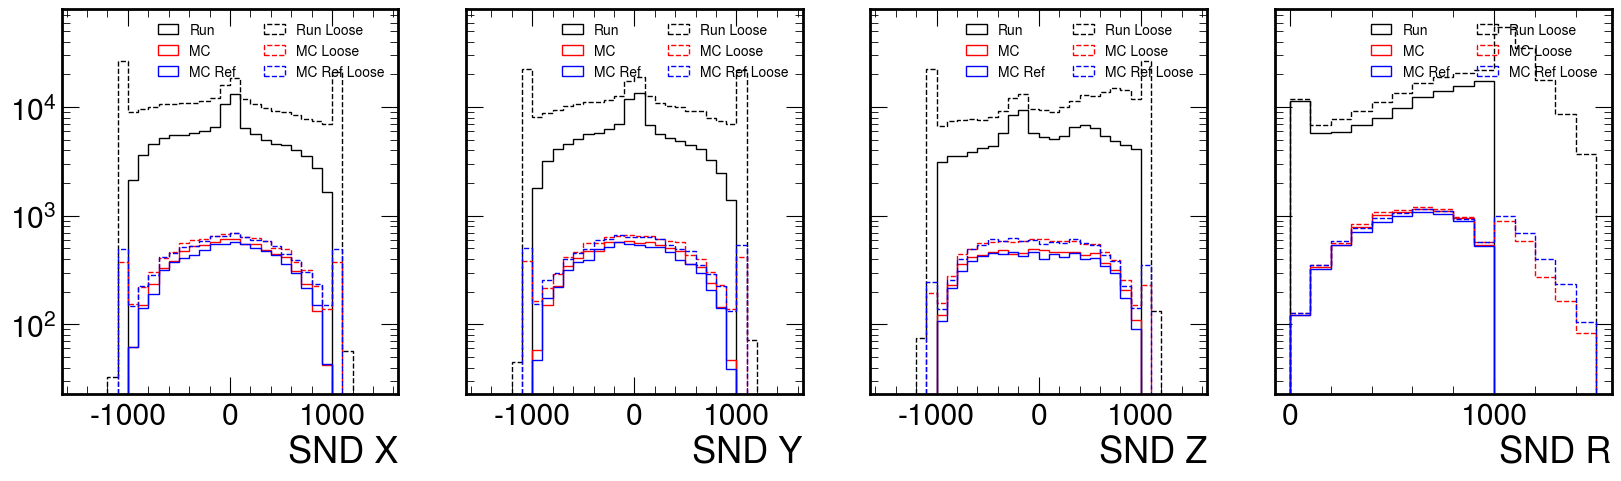

In [232]:
# Fiducial volume event cut - r,z
fid_cut = [1000,1000] 
fid_cut_loose = [1500,1500]

run.create_fiducial_volume_mask(z_cut=fid_cut[1], r_cut=fid_cut[0], use_snd=True, mask_name='snd_fiducial')
mc.create_fiducial_volume_mask(z_cut=fid_cut[1], r_cut=fid_cut[0], use_snd=True, mask_name='snd_fiducial')
mcRef.create_fiducial_volume_mask(z_cut=fid_cut[1], r_cut=fid_cut[0], use_snd=True, mask_name='snd_fiducial')

run.create_fiducial_volume_mask(z_cut=fid_cut_loose[1], r_cut=fid_cut_loose[0], use_snd=True, mask_name='snd_fiducial_loose')
mc.create_fiducial_volume_mask(z_cut=fid_cut_loose[1], r_cut=fid_cut_loose[0], use_snd=True, mask_name='snd_fiducial_loose')
mcRef.create_fiducial_volume_mask(z_cut=fid_cut_loose[1], r_cut=fid_cut_loose[0], use_snd=True, mask_name='snd_fiducial_loose')

def get_snd_reco_xyzr(analysis,fid_mask_name='snd_fiducial'):
    x = analysis.output_data['x_seedndestroy']
    y = analysis.output_data['y_seedndestroy'] 
    z = analysis.output_data['z_seedndestroy']
    r = np.sqrt(analysis.output_data['x_seedndestroy']**2+analysis.output_data['y_seedndestroy']**2)
    mask = analysis.masks[fid_mask_name]
    return x[mask], y[mask], z[mask], r[mask]

run_snd = get_snd_reco_xyzr(run,fid_mask_name='snd_fiducial')
mc_snd = get_snd_reco_xyzr(mc,fid_mask_name='snd_fiducial')
mcRef_snd = get_snd_reco_xyzr(mcRef,fid_mask_name='snd_fiducial')

run_snd_loose = get_snd_reco_xyzr(run,fid_mask_name='snd_fiducial_loose')
mc_snd_loose = get_snd_reco_xyzr(mc,fid_mask_name='snd_fiducial_loose')
mcRef_snd_loose = get_snd_reco_xyzr(mcRef,fid_mask_name='snd_fiducial_loose')

fig,ax = plt.subplots(1,4,figsize=(20,5),sharey=True)

xyzbinning=np.arange(-1500,1500+100,100)
rbinning=np.arange(0,1500+100,100)

ax[0].hist(run_snd[0],xyzbinning,histtype='step',color='black',label='Run',density=False)
ax[0].hist(mc_snd[0],xyzbinning,histtype='step',color='red',label='MC',density=False)
ax[0].hist(mcRef_snd[0],xyzbinning,histtype='step',color='blue',label='MC Ref',density=False)
ax[0].hist(run_snd_loose[0],xyzbinning,histtype='step',color='black',ls='--',label='Run Loose',density=False)
ax[0].hist(mc_snd_loose[0],xyzbinning,histtype='step',color='red',ls='--',label='MC Loose',density=False)
ax[0].hist(mcRef_snd_loose[0],xyzbinning,histtype='step',color='blue',ls='--',label='MC Ref Loose',density=False)
ax[0].legend(loc='upper right',fontsize=10,ncol=2)
ax[0].set_xlabel('SND X')
ax[0].semilogy()

ax[1].hist(run_snd[1],xyzbinning,histtype='step',color='black',label='Run',density=False)
ax[1].hist(mc_snd[1],xyzbinning,histtype='step',color='red',label='MC',density=False)
ax[1].hist(mcRef_snd[1],xyzbinning,histtype='step',color='blue',label='MC Ref',density=False)
ax[1].hist(run_snd_loose[1],xyzbinning,histtype='step',color='black',ls='--',label='Run Loose',density=False)
ax[1].hist(mc_snd_loose[1],xyzbinning,histtype='step',color='red',ls='--',label='MC Loose',density=False)
ax[1].hist(mcRef_snd_loose[1],xyzbinning,histtype='step',color='blue',ls='--',label='MC Ref Loose',density=False)
ax[1].legend(loc='upper right',fontsize=10,ncol=2)
ax[1].set_xlabel('SND Y')
ax[1].semilogy()

ax[2].hist(run_snd[2],xyzbinning,histtype='step',color='black',label='Run',density=False)
ax[2].hist(mc_snd[2],xyzbinning,histtype='step',color='red',label='MC',density=False)
ax[2].hist(mcRef_snd[2],xyzbinning,histtype='step',color='blue',label='MC Ref',density=False)
ax[2].hist(run_snd_loose[2],xyzbinning,histtype='step',color='black',ls='--',label='Run Loose',density=False)
ax[2].hist(mc_snd_loose[2],xyzbinning,histtype='step',color='red',ls='--',label='MC Loose',density=False)
ax[2].hist(mcRef_snd_loose[2],xyzbinning,histtype='step',color='blue',ls='--',label='MC Ref Loose',density=False)
ax[2].legend(loc='upper right',fontsize=10,ncol=2)
ax[2].set_xlabel('SND Z')
ax[2].semilogy()

ax[3].hist(run_snd[3],rbinning,histtype='step',color='black',label='Run',density=False)
ax[3].hist(mc_snd[3],rbinning,histtype='step',color='red',label='MC',density=False)
ax[3].hist(mcRef_snd[3],rbinning,histtype='step',color='blue',label='MC Ref',density=False)
ax[3].hist(run_snd_loose[3],rbinning,histtype='step',color='black',ls='--',label='Run Loose',density=False)
ax[3].hist(mc_snd_loose[3],rbinning,histtype='step',color='red',ls='--',label='MC Loose',density=False)
ax[3].hist(mcRef_snd_loose[3],rbinning,histtype='step',color='blue',ls='--',label='MC Ref Loose',density=False)
ax[3].legend(loc='upper right',fontsize=10,ncol=2)
ax[3].set_xlabel('SND R')
ax[3].semilogy()

In [240]:
# dt_masks = run.compute_low_energy_delayed_times(low_name='ben_low_energy_raw',high_name='ben_high_energy_raw',min_time_window_us=1,max_time_window_us=20)
# run_ben_raw = fit_muon_lifetime(run)

# dt_masks = run.compute_low_energy_delayed_times(low_name='ben_low_energy_raw',high_name='ben_high_energy_raw',min_time_window_us=1,max_time_window_us=200)
# run_ben_raw_long= fit_muon_lifetime(run)

dt_masks = run.compute_low_energy_delayed_times_newer(low_name='ben_low_energy_clean_tight',high_name='ben_high_energy_clean_tight',min_time_window_us=1,max_time_window_us=20)
run_ben_clean_tight = fit_muon_lifetime(run)
run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,20),low_energy_mask_name='ben_low_energy_clean_tight',michel_name='ben_michel_clean_tight',background_name='ben_background_clean_tight',old=False)

dt_masks = run.compute_low_energy_delayed_times_newer(low_name='ben_low_energy_clean_tight',high_name='ben_high_energy_clean_tight',min_time_window_us=1,max_time_window_us=200)
run_ben_clean_tight_long = fit_muon_lifetime(run)
run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,200),low_energy_mask_name='ben_low_energy_clean_tight',michel_name='ben_michel_clean_tight_long',background_name='ben_background_clean_tight_long')

dt_masks = run.compute_low_energy_delayed_times_newer(low_name='ben_low_energy_clean_loose',high_name='ben_high_energy_clean_loose',min_time_window_us=1,max_time_window_us=20)
run_ben_clean_loose = fit_muon_lifetime(run)
run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,20),low_energy_mask_name='ben_low_energy_clean_loose',michel_name='ben_michel_clean_loose',background_name='ben_background_clean_loose')

dt_masks = run.compute_low_energy_delayed_times_newer(low_name='ben_low_energy_clean_loose',high_name='ben_high_energy_clean_loose',min_time_window_us=1,max_time_window_us=200)
run_ben_clean_loose_long = fit_muon_lifetime(run)
run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,200),low_energy_mask_name='ben_low_energy_clean_loose',michel_name='ben_michel_clean_loose_long',background_name='ben_background_clean_loose_long')

# dt_masks = run.compute_low_energy_delayed_times_newer(low_name='ben_low_energy_clean_tight',high_name='ben_high_energy_clean_tight',fid_name='snd_fiducial',min_time_window_us=1,max_time_window_us=20)
# run_ben_clean_tight_fid = fit_muon_lifetime(run)
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,20),low_energy_mask_name='ben_low_energy_clean_tight',michel_name='ben_michel_clean_tight_fid',background_name='ben_background_clean_tight_fid')

# dt_masks = run.compute_low_energy_delayed_times_newer(low_name='ben_low_energy_clean_tight',high_name='ben_high_energy_clean_tight',fid_name='snd_fiducial',min_time_window_us=1,max_time_window_us=200)
# run_ben_clean_tight_long_fid = fit_muon_lifetime(run)
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,200),low_energy_mask_name='ben_low_energy_clean_tight',michel_name='ben_michel_clean_tight_long_fid',background_name='ben_background_clean_tight_long_fid')

# dt_masks = run.compute_low_energy_delayed_times_newer(low_name='ben_low_energy_clean_loose',high_name='ben_high_energy_clean_loose',fid_name='snd_fiducial',min_time_window_us=1,max_time_window_us=20)
# run_ben_clean_loose_fid = fit_muon_lifetime(run)
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,20),low_energy_mask_name='ben_low_energy_clean_loose',michel_name='ben_michel_clean_loose_fid',background_name='ben_background_clean_loose_fid')

# dt_masks = run.compute_low_energy_delayed_times_newer(low_name='ben_low_energy_clean_loose',high_name='ben_high_energy_clean_loose',fid_name='snd_fiducial',min_time_window_us=1,max_time_window_us=200)
# run_ben_clean_loose_long_fid = fit_muon_lifetime(run)
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,200),low_energy_mask_name='ben_low_energy_clean_loose',michel_name='ben_michel_clean_loose_long_fid',background_name='ben_background_clean_loose_long_fid')

# dt_masks = run.compute_low_energy_delayed_times_newer(low_name='ben_low_energy_clean_tight',high_name='ben_high_energy_clean_tight',cutmulti=False,min_time_window_us=1,max_time_window_us=20)
# run_ben_clean_tight_multi = fit_muon_lifetime(run)
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,20),low_energy_mask_name='ben_low_energy_clean_tight',michel_name='ben_michel_clean_tight_multi',background_name='ben_background_clean_tight_multi')

# dt_masks = run.compute_low_energy_delayed_times_newer(low_name='ben_low_energy_clean_tight',high_name='ben_high_energy_clean_tight',cutmulti=False,min_time_window_us=1,max_time_window_us=200)
# run_ben_clean_tight_long_multi = fit_muon_lifetime(run)
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,200),low_energy_mask_name='ben_low_energy_clean_tight',michel_name='ben_michel_clean_tight_long_multi',background_name='ben_background_clean_tight_long_multi')

# dt_masks = run.compute_low_energy_delayed_times_newer(low_name='ben_low_energy_clean_loose',high_name='ben_high_energy_clean_loose',cutmulti=False,min_time_window_us=1,max_time_window_us=20)
# run_ben_clean_loose_multi = fit_muon_lifetime(run)
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,20),low_energy_mask_name='ben_low_energy_clean_loose',michel_name='ben_michel_clean_loose_multi',background_name='ben_background_clean_loose')

# dt_masks = run.compute_low_energy_delayed_times_newer(low_name='ben_low_energy_clean_loose',high_name='ben_high_energy_clean_loose',cutmulti=False,min_time_window_us=1,max_time_window_us=200)
# run_ben_clean_loose_long_multi = fit_muon_lifetime(run)
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,200),low_energy_mask_name='ben_low_energy_clean_loose',michel_name='ben_michel_clean_loose_long_multi',background_name='ben_background_clean_loose_long_multi')

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan 

/tmp/ipykernel_219465/516841616.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(


(array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]))

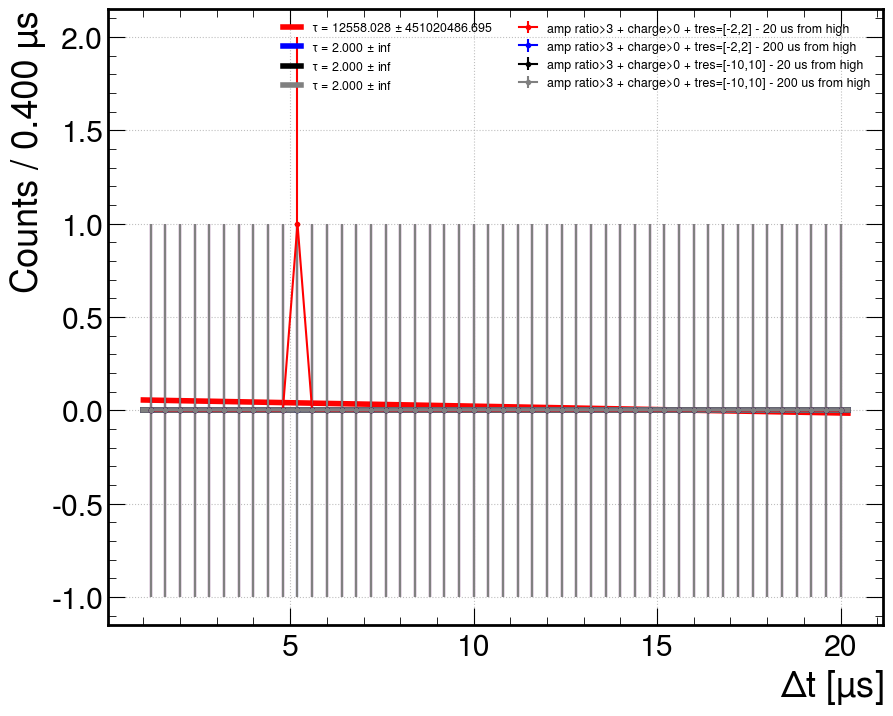

In [241]:
plt.figure(figsize=(10, 8))


def plot_fit(data,color,ls,label):
    bin_centers=(data[0][:-1]+data[0][1:])/2
    t_fine = np.linspace(data[0][0], data[0][-1], 1000)
    plt.plot(t_fine, decay_model(t_fine, *data[3]['popt']), ls=ls, color=color, lw=4, label=f"$\\tau$ = {data[4]:.3f} ± {data[5]:.3f}")
    plt.errorbar(bin_centers, data[1], yerr=data[2], ls=ls, fmt='o', ms=3, color=color,label=label)
    plt.xlabel("$\Delta$t [µs]")
    plt.ylabel(f"Counts / {data[0][1] - data[0][0]:.3f} µs")

# plot_fit(run_ben_raw,color='green',label='nhit 50 < low < 125 < high - no hit cleaning - search 20 us from high')
# plot_fit(run_ben_raw_long,color='black',label='nhit 50 < low < 125 < high - no hit cleaning - search 200 us from high')
plot_fit(run_ben_clean_tight,color='red',ls='-',label='amp ratio>3 + charge>0 + tres=[-2,2] - 20 us from high')
plot_fit(run_ben_clean_tight_long,color='blue',ls='-',label='amp ratio>3 + charge>0 + tres=[-2,2] - 200 us from high')
plot_fit(run_ben_clean_loose,color='black',ls='-',label='amp ratio>3 + charge>0 + tres=[-10,10] - 20 us from high')
plot_fit(run_ben_clean_loose_long,color='grey',ls='-',label='amp ratio>3 + charge>0 + tres=[-10,10] - 200 us from high')

# plot_fit(run_ben_clean_tight_fid,color='red',ls='--',label='amp ratio>3 + charge>0 + tres=[-2,2] + r&z<1000 - search forward 20 us from high')
# plot_fit(run_ben_clean_tight_long_fid,color='blue',ls='--',label='amp ratio>3 + charge>0 + tres=[-2,2] + r&z<1000 - 200 us from high')
# plot_fit(run_ben_clean_loose_fid,color='black',ls='--',label='amp ratio>3 + charge>0 + tres=[-10,10] + r&7<1000- search forward 20 us from high')
# plot_fit(run_ben_clean_loose_long_fid,color='grey',ls='--',label='amp ratio>3 + charge>0 + tres=[-10,10] + r&z<1000 -search forward 200 us from high')

# plot_fit(run_ben_clean_tight_multi,color='red',ls='--',label='amp ratio>3 + charge>0 + tres=[-2,2] - 20 us from high - no mulit cut')
# plot_fit(run_ben_clean_tight_long_multi,color='blue',ls='--',label='amp ratio>3 + charge>0 + tres=[-2,2] - 200 us from high - no multi cut')
# plot_fit(run_ben_clean_loose_multi,color='black',ls='--',label='amp ratio>3 + charge>0 + tres=[-10,10] - 20 us from high - no multi cut')
# plot_fit(run_ben_clean_loose_long_multi,color='grey',ls='--',label='amp ratio>3 + charge>0 + tres=[-10,10] - 200 us from high - no multi cut')

plt.grid(True)
plt.legend(ncol=2,fontsize=9)
plt.show()


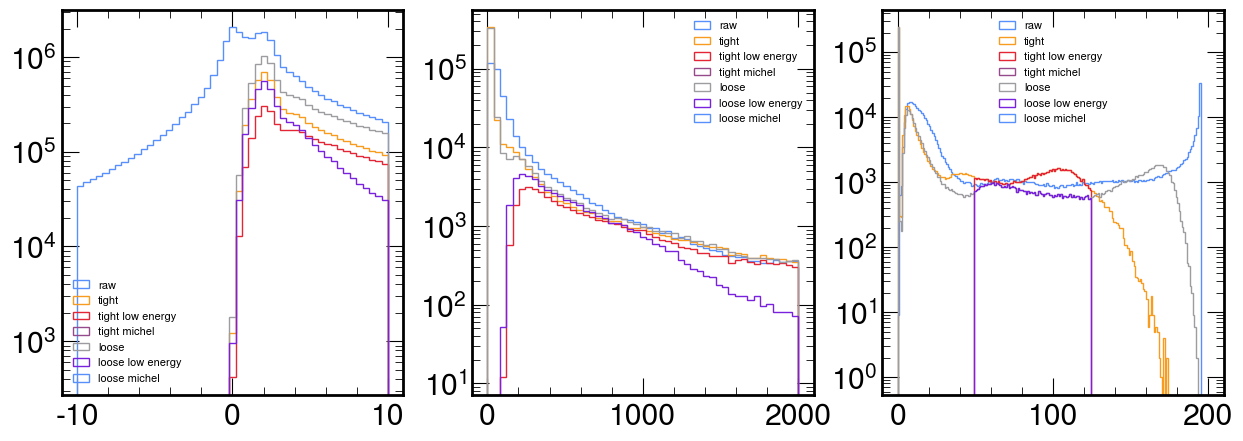

In [239]:
test_charges = run.get_hit_charges(hit_masks=None,event_masks=None)
test_charges1 = run.get_hit_charges(hit_masks=['hit_amplitude','hit_charge','tight_hit_time'],event_masks=None)
test_charges2 = run.get_hit_charges(hit_masks=['hit_amplitude','hit_charge','tight_hit_time'],event_masks=['ben_low_energy_clean_tight'])
test_charges3 = run.get_hit_charges(hit_masks=['hit_amplitude','hit_charge','tight_hit_time'],event_masks=['ben_low_energy_clean_tight','ben_michel_clean_tight'])
test_charges4 = run.get_hit_charges(hit_masks=['hit_amplitude','hit_charge','loose_hit_time'],event_masks=None)
test_charges5 = run.get_hit_charges(hit_masks=['hit_amplitude','hit_charge','loose_hit_time'],event_masks=['ben_low_energy_clean_loose'])
test_charges6 = run.get_hit_charges(hit_masks=['hit_amplitude','hit_charge','loose_hit_time'],event_masks=['ben_low_energy_clean_loose','ben_michel_clean_loose'])

hcbinning = np.linspace(-10,10,50)
tcbinning = np.linspace(0,2000,50)
nbinning = np.linspace(0,200,200)

fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].hist(ak.flatten(test_charges),hcbinning,histtype='step',label='raw')
ax[0].hist(ak.flatten(test_charges1),hcbinning,histtype='step',label='tight');
ax[0].hist(ak.flatten(test_charges2),hcbinning,histtype='step',label='tight low energy');
ax[0].hist(ak.flatten(test_charges3),hcbinning,histtype='step',label='tight michel');
ax[0].hist(ak.flatten(test_charges4),hcbinning,histtype='step',label='loose');
ax[0].hist(ak.flatten(test_charges5),hcbinning,histtype='step',label='loose low energy');
ax[0].hist(ak.flatten(test_charges6),hcbinning,histtype='step',label='loose michel');
ax[0].legend(fontsize=8)
ax[0].set_yscale('log')

ax[1].hist(ak.sum(test_charges,axis=1),tcbinning,histtype='step',label='raw')
ax[1].hist(ak.sum(test_charges1,axis=1),tcbinning,histtype='step',label='tight');
ax[1].hist(ak.sum(test_charges2,axis=1),tcbinning,histtype='step',label='tight low energy');
ax[1].hist(ak.sum(test_charges3,axis=1),tcbinning,histtype='step',label='tight michel');
ax[1].hist(ak.sum(test_charges4,axis=1),tcbinning,histtype='step',label='loose');
ax[1].hist(ak.sum(test_charges5,axis=1),tcbinning,histtype='step',label='loose low energy');
ax[1].hist(ak.sum(test_charges6,axis=1),tcbinning,histtype='step',label='loose michel');
ax[1].legend(fontsize=8)
ax[1].set_yscale('log')

ax[2].hist(ak.count(test_charges,axis=1),nbinning,histtype='step',label='raw')
ax[2].hist(ak.count(test_charges1,axis=1),nbinning,histtype='step',label='tight');
ax[2].hist(ak.count(test_charges2,axis=1),nbinning,histtype='step',label='tight low energy');
ax[2].hist(ak.count(test_charges3,axis=1),nbinning,histtype='step',label='tight michel');
ax[2].hist(ak.count(test_charges4,axis=1),nbinning,histtype='step',label='loose');
ax[2].hist(ak.count(test_charges5,axis=1),nbinning,histtype='step',label='loose low energy');
ax[2].hist(ak.count(test_charges6,axis=1),nbinning,histtype='step',label='loose michel');
ax[2].legend(fontsize=8)
ax[2].set_yscale('log')

In [99]:
run_clean_loose_charges = run.get_hit_charges(hit_masks=hit_cleaning_masks_loose,event_masks=['ben_michel_clean_loose_multi'])
run_clean_loose_long_charges = run.get_hit_charges(hit_masks=hit_cleaning_masks_loose,event_masks=['ben_michel_clean_loose_multi'])
run_clean_loose_charges = run.get_hit_charges(hit_masks=hit_cleaning_masks_loose,event_masks=['ben_michel_clean_loose_multi'])

print(run.masks)
mc_clean_loose_charges = mc.get_hit_charges(hit_masks=hit_cleaning_masks_loose,event_masks=['ben_low_energy_clean_loose'])

# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,200),low_energy_mask_name='ben_low_energy_clean_tight',michel_name='ben_michel_clean_tight_long',background_name='ben_background_clean_tight_long')
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,20),low_energy_mask_name='ben_low_energy_clean_loose',michel_name='ben_michel_clean_loose',background_name='ben_background_clean_loose')
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,200),low_energy_mask_name='ben_low_energy_clean_loose',michel_name='ben_michel_clean_loose_long',background_name='ben_background_clean_loose_long')
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,20),low_energy_mask_name='ben_low_energy_clean_tight',michel_name='ben_michel_clean_tight_fid',background_name='ben_background_clean_tight_fid')
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,200),low_energy_mask_name='ben_low_energy_clean_tight',michel_name='ben_michel_clean_tight_long_fid',background_name='ben_background_clean_tight_long_fid')
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,20),low_energy_mask_name='ben_low_energy_clean_loose',michel_name='ben_michel_clean_loose_fid',background_name='ben_background_clean_loose_fid')
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,200),low_energy_mask_name='ben_low_energy_clean_loose',michel_name='ben_michel_clean_loose_long_fid',background_name='ben_background_clean_loose_long_fid')
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,20),low_energy_mask_name='ben_low_energy_clean_tight',michel_name='ben_michel_clean_tight_multi',background_name='ben_background_clean_tight_multi')
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,200),low_energy_mask_name='ben_low_energy_clean_tight',michel_name='ben_michel_clean_tight_long_multi',background_name='ben_background_clean_tight_long_multi')
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,20),low_energy_mask_name='ben_low_energy_clean_loose',michel_name='ben_michel_clean_loose_multi',background_name='ben_background_clean_loose')
# run.create_low_energy_time_masks(michel_range=(1,5),background_range=(15,200),low_energy_mask_name='ben_low_energy_clean_loose',michel_name='ben_michel_clean_loose_long_multi',background_name='ben_background_clean_loose_long_multi')

{'hit_amplitude': <Array [[False, False, ..., False, False], ...] type='5000576 * var * bool'>, 'hit_charge': <Array [[False, False, ..., True, True], ...] type='5000576 * var * bool'>, 'tight_hit_time_snd_log': <Array [[False, False, ..., False, False], ...] type='5000576 * var * bool'>, 'weird_hit_time_snd_log': <Array [[False, False, ..., False, False], ...] type='5000576 * var * bool'>, 'loose_hit_time_snd_log': <Array [[False, False, ..., False, False], ...] type='5000576 * var * bool'>, 'snd_log_fiducial': <Array [False, False, False, ..., False, False, False] type='5000576 * bool'>, 'tight_hit_time_quad_log': <Array [[False, False, ..., False, False], ...] type='5000576 * var * bool'>, 'weird_hit_time_quad_log': <Array [[False, False, ..., False, False], ...] type='5000576 * var * bool'>, 'loose_hit_time_quad_log': <Array [[False, False, ..., False, False], ...] type='5000576 * var * bool'>, 'quad_log_fiducial': <Array [False, False, False, ..., True, False, False] type='5000576

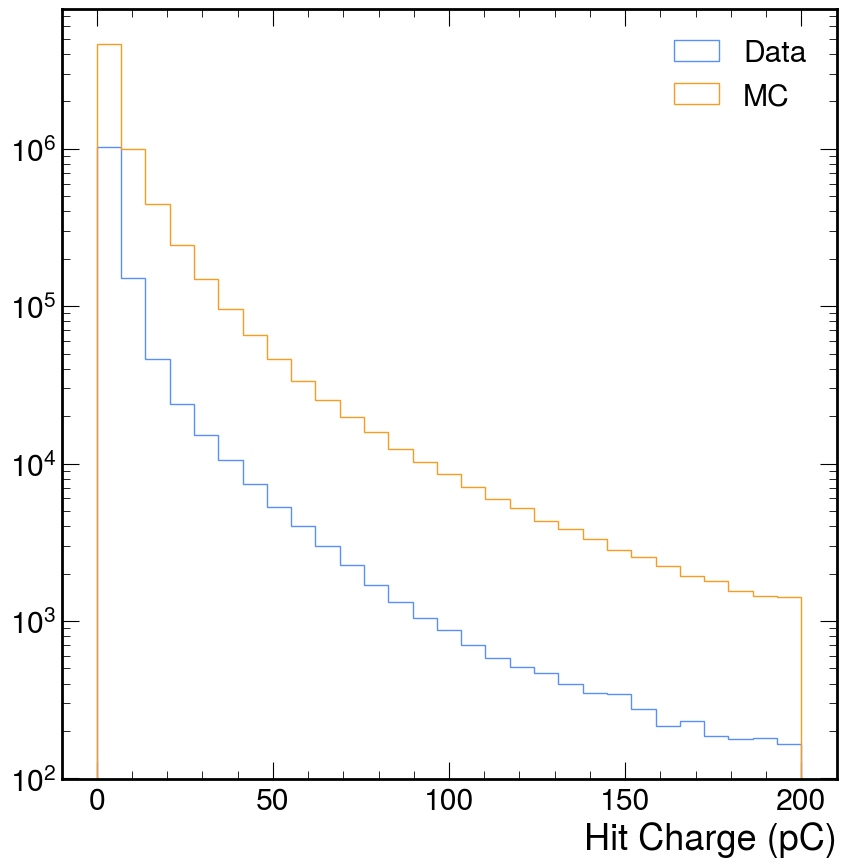

In [100]:



bin_edges = np.linspace(0,200,30)

plt.hist(ak.flatten(run_clean_loose_charges),bin_edges,histtype='step',density=False,label='Data')
plt.hist(ak.flatten(mc_clean_loose_charges),bin_edges,histtype='step',density=False,label='MC')
plt.yscale('log')
plt.xlabel('Hit Charge (pC)')
plt.legend()


In [101]:

bin_edges = np.linspace(0,2000,30)

plt.hist(ak.sum(run_clean_tight_charges,axis=1),bin_edges,histtype='step',density=True,label='Data')
plt.hist(ak.sum(mc_clean_tight_charges,axis=1),bin_edges,histtype='step',density=True,label='MC')
plt.yscale('log')
plt.xlabel('Event Charge (pC)')
plt.legend()

NameError: name 'run_clean_tight_charges' is not defined

In [ ]:

bin_edges = np.linspace(0,200,30)

plt.hist(ak.count(run_clean_tight_charges,axis=1),bin_edges,histtype='step',density=True,label='Data')
plt.hist(ak.count(mc_clean_tight_charges,axis=1),bin_edges,histtype='step',density=True,label='MC')
plt.yscale('log')
plt.xlabel('Event Nhit')
plt.legend()

In [ ]:


import matplotlib.pyplot as plt
import numpy as np

high_name = 'tanner_high_energy_raw'
low_name = 'tanner_low_energy_raw'
good_high_indices = dt_masks['good_high_indices']
good_low_indices = dt_masks['good_low_indices']

# Convert cumulative dt_us into absolute timestamps
timestamps_us = np.cumsum(run.output_data['timeSinceLastTrigger_us'])

plt.figure(figsize=(12,5))
plt.plot(timestamps_us, np.zeros_like(timestamps_us), 'k.', alpha=0.3, label='All events')

# Mark high/low candidates
plt.plot(timestamps_us[run.masks[high_name]], np.ones(np.sum(run.masks[high_name]))*0.1,
         'ro', label='High candidates', alpha=0.5)
plt.plot(timestamps_us[run.masks[low_name]], np.ones(np.sum(run.masks[low_name]))*-0.1,
         'bo', label='Low candidates', alpha=0.5)

# Mark accepted pairs
plt.plot(timestamps_us[good_high_indices], np.ones(len(good_high_indices))*0.2,
         'r*', markersize=12, label='Accepted high')
plt.plot(timestamps_us[good_low_indices], np.ones(len(good_low_indices))*-0.2,
         'b*', markersize=12, label='Accepted low')

plt.xlabel("Time [µs]")
plt.yticks([])
plt.legend()
plt.title("Event selection timeline")
plt.xlim(130743947712,130743947712+400)
plt.show()


In [ ]:

# Step 5: Create Michel signal and background time windows
run.create_low_energy_time_masks(michel_range=(1, 5),background_range=(20, 400))

In [ ]:
# Get Michel signal events with all cuts applied
michel_charges = run.get_hit_charges(
    hit_masks=['hit_amplitude', 'hit_charge', 'hit_time'],
    event_masks=['michel_signal', 'fiducial']
)
print(f"Michel events: {len(michel_charges)}")

In [ ]:
# Get background events
background_charges = run.get_hit_charges(
    hit_masks=['hit_amplitude', 'hit_charge', 'hit_time'],
    event_masks=['michel_background', 'fiducial']
)
print(f"Background events: {len(background_charges)}")


In [ ]:
# Calculate nhits for different event categories
low_energy_nhits = run.get_nhits(
    hit_masks=['hit_amplitude', 'hit_charge', 'hit_time'],
    event_masks=['low_energy', 'fiducial']
)
print(f"Low energy events after cuts: {len(low_energy_nhits)}")

In [ ]:
# Compute coincident hits for Michel events
coinc_hits, coinc_err = run.compute_coincident_hits(
    hit_masks=['hit_amplitude', 'hit_charge', 'hit_time'],
    event_masks=['michel_signal', 'fiducial'],
    normalize_by_events=False
)
print(f"Computed coincident hits for {np.sum(run.masks['michel_signal'] & run.masks['fiducial'])} Michel events")
print(f"Hits per PMT ID over all events: {coinc_hits}")


In [ ]:
michel_nhits = run.get_nhits(
    hit_masks=['hit_amplitude', 'hit_charge', 'hit_time'],
    event_masks=['michel_signal', 'fiducial']
)
print(f"Michel events after cuts: {len(michel_nhits)}")

In [ ]:
# Print summary
run.summary()

In [ ]:
# Test different cut variations:

# Test looser time cuts
run.create_hit_time_mask(time_range=(-15, 15), mask_name='hit_time_loose')

loose_michel_charges = run.get_hit_charges(
    hit_masks=['hit_amplitude', 'hit_charge', 'hit_time_loose'],
    event_masks=['michel_signal', 'fiducial']
)
print(f"Michel events with looser time cuts: {len(loose_michel_charges)}")

# Test different energy thresholds
run.create_energy_masks(
    high_energy_min=100,  # lower threshold
    low_energy_min=40,
    hit_masks=['hit_amplitude', 'hit_charge', 'hit_time']
)

# The masks get updated with new names automatically
print(f"Available masks now: {list(run.masks.keys())}")

In [ ]:




class Run:
    def __init__(self, file, nevents):
        self.file = Path(file) 
        self.nevents = nevents
        # Root file variables 
        self.meta_data = None
        self.output_data = None
        # Is Online
        self.pmt_is_online = None 
        # Hit cleaning masks
        self.hit_amp_mask = None
        self.hit_charge_mask = None
        self.hit_time_mask = None        
        self.hit_tof = None
        self.event_hit_times = None
        self.hit_time_res = None
        # Hit cleaned data
        self.clean_charges = None
        self.clean_nhit = None
        # Event selection masks 
        self.fid_vol_event_mask = None
        self.prompt_raw_mask = None
        self.delayed_raw_mask = None 
        self.prompt_clean_mask = None 
        self.delayed_clean_mask = None 
        # Event selected data
        self.delayed_dt = None
        self.delayed_dt_mask = None 
        self.final_event_mask = None 
        self.final_background_mask = None
        self.final_charges = None 
        self.background_charges = None
        # # Timing variables for plotting
        # self.clock_period = 0.5  # us
        # self.start_time = 1 #3 * 0.432 + self.clock_period # 0  # e.g., 0.864 us
        # self.nclock_cycles_to_plot = 40
        # self.stop_time = self.start_time + (self.nclock_cycles_to_plot) * self.clock_period  # e.g., 0.912
        # PMT ids for plotting  
        self.barrel_ids = None 
        self.bottom_ids = None 
        self.dichroic_ids = None 
        self.top_ids = None 
        self.behind_ids = None 

    def print_nevents_in_file(self):
        f = up.open(self.file)
        print(f"There are {f['output'].num_entries} events in {self.file}")

    def load_meta_data(self):
        f = up.open(self.file)
        print(f"Meta Keys: {f['meta'].keys()}")
        start = time.time() 
        self.meta_data = f['meta'].arrays([
            'pmtType',
            'pmtId',
            'pmtChannel',
            'pmtIsOnline',
            'pmtCableOffset',
            'pmtX',
            'pmtY',
            'pmtZ',
        ], entry_start=0, entry_stop=1, library='ak') 
        stop = time.time()
        print(f"Took {stop-start:.2f} seconds to load meta data for {self.nevents} events")

    def load_event_data(self):
        f=up.open(self.file)
        print(f"Output Keys: {f['output'].keys()}")
        start = time.time()
        self.output_data = f['output'].arrays([
            'timestamp',
            'triggerTime',
            'timeSinceLastTrigger_us',
            'digitPMTID',
            'digitTime',
            'digitCharge',
            'digitHitCleaningMask',
            'fit_time_Lognormal',
            'x_quadfitter',
            'y_quadfitter',
            'z_quadfitter',
            'validposition_quadfitter',
            'time_quadfitter',
            'validtime_quadfitter',
            'x_seedndestroy',
            'y_seedndestroy',
            'z_seedndestroy',
            'validposition_seedndestroy',
            'time_seedndestroy',
            'validtime_seedndestroy',
        ], entry_start=0, entry_stop=self.nevents, library='ak')
        stop = time.time()
        print(f"Took {stop-start:.2f} seconds to load output data for {self.nevents} events")

    # step 1 
    def calculate_time_residuals(self,snd=True):
        
        # Which fitter to use 
        if snd:
            event_time = self.output_data['time_seedndestroy']
            fitx = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['x_seedndestroy'])[1]
            fity = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['y_seedndestroy'])[1]
            fitz = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['z_seedndestroy'])[1]
            valid_fit = self.output_data['validtime_seedndestroy'] & self.output_data['validposition_seedndestroy']
        else:
            event_time = self.output_data['time_quadfitter']
            fitx = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['x_quadfitter'])[1]
            fity = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['y_quadfitter'])[1]
            fitz = ak.broadcast_arrays(self.output_data['digitPMTID'], self.output_data['z_quadfitter'])[1]
            valid_fit = self.output_data['validtime_quadfitter'] & self.output_data['validposition_quadfitter']

        valid_fit = self.output_data['validtime_quadfitter'] & self.output_data['validposition_quadfitter']
        hit_time = self.output_data['fit_time_Lognormal']
        event_time = ak.broadcast_arrays(hit_time, event_time)[1]
        self.event_hit_times = event_time
        pmtX = ak.Array(self.meta_data['pmtX'][0])
        pmtY = ak.Array(self.meta_data['pmtY'][0])
        pmtZ = ak.Array(self.meta_data['pmtZ'][0])
        hitx_flat = pmtX[ak.flatten(self.output_data['digitPMTID'])]
        hity_flat = pmtY[ak.flatten(self.output_data['digitPMTID'])]
        hitz_flat = pmtZ[ak.flatten(self.output_data['digitPMTID'])]
        hitx = ak.unflatten(hitx_flat, ak.num(self.output_data['digitPMTID']))
        hity = ak.unflatten(hity_flat, ak.num(self.output_data['digitPMTID']))
        hitz = ak.unflatten(hitz_flat, ak.num(self.output_data['digitPMTID'])) 
        dist = np.sqrt((fitx - hitx)**2 + (fity - hity)**2 + (fitz - hitz)**2)
        hit_tof = dist / 224 # speed of light in water [mm/ns]
        #self.hit_tof = ak.where(valid_fit, hit_tof, np.nan)
        self.hit_tof = hit_tof
        hit_time_res = hit_time - event_time - hit_tof 
        #print("fit",ak.sum(valid_fit),ak.sum(~valid_fit))
        valid_fit = ak.broadcast_arrays(hit_time, valid_fit)[1]
        self.hit_time_res = ak.where(valid_fit, hit_time_res, np.nan)
        #print(ak.sum(np.isnan(self.hit_time_res)), ak.sum(np.isnan(self.hit_time_res),axis=1))

    # Debug for step 1 (shouldn't compare time residuals with MC until after final michel event selection)
    def plot_timing_corrections(self, nbins=400, trange=(-20,20), figsize=(10,5), fontsize=10, loc='upper right'):

        plt.figure(figsize=figsize)
        # Raw times
        times = self.output_data['fit_time_Lognormal']
        plt.hist(ak.flatten(times), bins=nbins, range=trange, histtype='step',label='Digit Hit Time', color='blue')\
        # Event (fit) time correction
        times_ev = times - self.event_hit_times
        plt.hist(ak.flatten(times_ev), bins=nbins, range=trange, histtype='step', label='Digit Hit Time - Reco Event Time', color='orange')
        # Time-of-flight correction
        times_ev_tof = times_ev - self.hit_tof
        plt.hist(ak.flatten(times_ev_tof), bins=nbins, range=trange, histtype='step', label='Digit Hit Time - Reco Event Time - TOF', color='green')
        plt.xlabel('Hit Time [ns]',fontsize=fontsize)
        plt.ylabel('Counts',fontsize=fontsize)
        plt.title('Hit Times Across All Channels and Events',fontsize=fontsize)
        plt.legend(loc=loc,fontsize=fontsize)
        plt.tight_layout()
        plt.yscale('log')
        plt.show()


    # step 2 
    def make_hit_cleaning_masks(self,time_cut):

        # Amplitude mask 
        self.hit_amp_mask = ((self.output_data['digitHitCleaningMask'] >> 1) & 1) == 0
        # Charge mask 
        charge = self.output_data['digitCharge']
        self.hit_charge_mask = charge > 0
        # Timing mask 
        self.hit_time_mask = (self.hit_time_res > time_cut[0]) & (self.hit_time_res < time_cut[1])

    
    # step 3
    def make_fiducial_volume_mask(self,snd=True,zcut=600,rcut=600):

        if snd:
            x_fit = self.output_data['x_seedndestroy']
            y_fit = self.output_data['y_seedndestroy']
            z_fit = self.output_data['z_seedndestroy']
        else:
            x_fit = self.output_data['x_quadfitter']
            y_fit = self.output_data['y_quadfitter']
            z_fit = self.output_data['z_quadfitter']


        self.fid_vol_event_mask = (zcut > z_fit) & (z_fit > -zcut) & (rcut > np.sqrt(x_fit**2 + y_fit**2))


    # step 4 (apply all the cuts and sort based on nhit) 
    def make_cleaned_and_raw_nhit_masks(self, prompt_min_nhit=125, delayed_min_nhit=50):

        # Get raw data
        charges = self.output_data['digitCharge']

        # Apply all hit cuts together
        clean_charges = ak.mask(charges, self.hit_amp_mask & self.hit_time_mask & self.hit_charge_mask)

        # Calculate NHits
        raw_nhit = ak.count(charges, axis=1)
        clean_nhit = ak.count(clean_charges, axis=1)

        # Save important stuff
        self.clean_charges = clean_charges
        self.clean_nhit = clean_nhit

        # Make trigger type masks 
        prompt_raw_mask = raw_nhit >= prompt_min_nhit
        delayed_raw_mask = (raw_nhit >= delayed_min_nhit) & (raw_nhit < prompt_min_nhit)
        prompt_clean_mask = clean_nhit >= prompt_min_nhit
        delayed_clean_mask = (clean_nhit >= delayed_min_nhit) & (clean_nhit < prompt_min_nhit)

        # Save important stuff
        self.prompt_clean_mask = prompt_clean_mask 
        self.delayed_clean_mask = delayed_clean_mask
        self.prompt_raw_mask = prompt_raw_mask 
        self.delayed_raw_mask = delayed_raw_mask


    # Debug for step 4
    def plot_cleaned_and_raw_charges(self,hist_nbins=200,hist_crange=(-10,10),fontsize=20,figsize=(10,5),loc='upper left'):

        # Get charges and apply masks one by one
        raw = self.output_data['digitCharge']
        amp_cut = ak.mask(raw, self.hit_amp_mask)
        amp_time_cut = ak.mask(raw, self.hit_amp_mask & self.hit_time_mask) 
        amp_time_charge_cut = ak.mask(raw, self.hit_amp_mask & self.hit_time_mask & self.hit_charge_mask)
        amp_time_charge_fid_cut = ak.mask(raw, self.hit_amp_mask & self.hit_time_mask & self.hit_charge_mask & self.fid_vol_event_mask)

        # Flatten for plotting
        raw = ak.to_numpy(ak.flatten(raw))
        amp_cut= ak.to_numpy(ak.flatten(amp_cut))
        amp_time_cut = ak.to_numpy(ak.flatten(amp_time_cut))
        amp_time_charge_cut = ak.to_numpy(ak.flatten(amp_time_charge_cut))
        amp_time_charge_fid_cut = ak.to_numpy(ak.flatten(amp_time_charge_fid_cut))

        # Plot total charge
        plt.figure(figsize=figsize)
        plt.hist(raw,bins=hist_nbins,range=hist_crange,histtype='step',label=f"digitCharge")
        plt.hist(amp_cut,bins=hist_nbins,range=hist_crange,histtype='step',label=f"digitCharge after cross-talk cut")
        plt.hist(amp_time_cut,bins=hist_nbins,range=hist_crange,histtype='step',label=f"digitCharge after cross-talk + hit time cut")
        plt.hist(amp_time_charge_cut,bins=hist_nbins,range=hist_crange,histtype='step',label=f"digitCharge after cross-talk + hit time + hit charge cut")
        plt.hist(amp_time_charge_fid_cut,bins=hist_nbins,range=hist_crange,histtype='step',label=f"digitCharge after cross-talk + hit time + hit charge + fiducial volume event cut")
        plt.title('EOS Run 3056 (Water Fill)',fontsize=fontsize)
        plt.xlabel('Hit Charge [pC]',fontsize=fontsize)
        plt.ylabel('Counts',fontsize=fontsize)
        plt.semilogy()
        plt.legend(loc=loc,fontsize=fontsize)

    # More debug for step 4
    def plot_cleaned_and_raw_nhit(self, max_nhit=200, fontsize=20, figsize=(10,5),loc='upper right'):

        # Get charges
        raw = self.output_data['digitCharge']
        amp_cut = ak.mask(raw, self.hit_amp_mask)
        amp_time_cut = ak.mask(raw, self.hit_amp_mask & self.hit_time_mask) 
        amp_time_charge_cut = ak.mask(raw, self.hit_amp_mask & self.hit_time_mask & self.hit_charge_mask)
        amp_time_charge_fid_cut = ak.mask(raw, self.hit_amp_mask & self.hit_time_mask & self.hit_charge_mask & self.fid_vol_event_mask)

        # Calculate NHits
        raw_nhit = ak.count(raw, axis=1)
        amp_nhit = ak.count(amp_cut, axis=1)
        amp_time_nhit = ak.count(amp_time_cut, axis=1) 
        amp_time_charge_nhit = ak.count(amp_time_charge_cut, axis=1)
        amp_time_charge_fid_nhit = ak.count(amp_time_charge_fid_cut, axis=1)

        # Plot NHits
        plt.figure(figsize=figsize)
        plt.hist(raw_nhit,bins=max_nhit,range=(0,max_nhit),histtype='step',label=f"Nhits")
        plt.hist(amp_nhit,bins=max_nhit,range=(0,max_nhit),histtype='step',label=f"Nhits after cross-talk cut")
        plt.hist(amp_time_nhit,bins=max_nhit,range=(0,max_nhit),histtype='step',label=f"Nhits after cross-talk + hit time cut")
        plt.hist(amp_time_charge_nhit,bins=max_nhit,range=(0,max_nhit),histtype='step',label=f"Nhits after cross-talk + hit time + charge cut")
        plt.hist(amp_time_charge_fid_nhit,bins=max_nhit,range=(0,max_nhit),histtype='step',label=f"Nhits after cross-talk + hit time + charge + fiducial volume event cut")
        plt.title('EOS Run 3056 (Water Fill)',fontsize=fontsize)
        plt.xlabel('NHits',fontsize=fontsize)
        plt.ylabel('Number of Events',fontsize=fontsize)
        plt.semilogy()
        plt.legend(loc=loc,fontsize=fontsize)


    # Step 5 (of course only for run data, not MC)
    def compute_delayed_times_relative_to_prompt_with_ts(self):

        prompt_mask = self.prompt_clean_mask
        delayed_mask = self.delayed_clean_mask

        timestamps = self.output_data['timestamp']
        timestamps = np.asarray(timestamps)
        prompt_times = timestamps[prompt_mask]
        delayed_times = timestamps[delayed_mask]

        delta_ts = []
        i_prompt = 0

        for delayed_time in delayed_times:
            # Advance through prompt_times as long as they're in the past
            while i_prompt + 1 < len(prompt_times) and prompt_times[i_prompt + 1] < delayed_time:
                i_prompt += 1

            if prompt_times[i_prompt] < delayed_time:
                delta_ts.append(delayed_time - prompt_times[i_prompt])

            else:
                # No prior prompt found (e.g., delayed event came before all prompts)
                delta_ts.append(np.nan)

        self.delayed_dt = np.array(delta_ts)

    # Debug step 5 
    def plot_nhit_dt(self):

        dt_clean = self.delayed_dt
        delayed_clean_mask = self.delayed_clean_mask 
        clean_nhit = self.clean_nhit

        # print(dt_clean)
        # print(delayed_clean_mask)
        # print(clean_nhit)

        valid_dt_clean_mask = ~np.isnan(dt_clean)

        dt_clean_np = ak.to_numpy(dt_clean[valid_dt_clean_mask])
        clean_nhit_np = ak.to_numpy(clean_nhit[delayed_clean_mask][valid_dt_clean_mask])

        clock_period = 0.016 # us
        nclock_ticks = 100
        follower_start_time = 0.432  # us
   
        plt.hist2d(dt_clean_np/1e3, clean_nhit_np,bins=(nclock_ticks,100),range=((follower_start_time,follower_start_time+clock_period*(nclock_ticks-1)),(0,200)),norm='log');
        plt.axvline(0.864)
        plt.xlabel("$\Delta$t [µs]")
        plt.ylabel('NHits')
        plt.title('Michel Candidates')
        plt.show()

        plt.hist2d(dt_clean_np/1e3, clean_nhit_np,bins=(100,100),range=((0,400),(0,200)),norm='log');
        plt.axvline(0.864)
        plt.xlabel("$\Delta$t [µs]")
        plt.ylabel('NHits')
        plt.title('Michel Candidates')
        plt.show()

        tts = np.unique(dt_clean_np)
        # for t in tts[:50]:
        #     print(t)
        # print(np.unique(np.diff(np.unique(dt_clean_np))))

    
    # Step 6 (of course only for run data, not MC)
    def fit_muon_lifetime(self,start_time=0, stop_time=20, bin_width= 0.5):
 
 
        # Construct bin centers 
        bin_edges = np.arange(start_time, stop_time+bin_width, bin_width)
        print(bin_edges)
        pmask = (self.delayed_dt/1e3> start_time) & (self.delayed_dt/1e3<= stop_time)
 
        # # Construct bin edges from centers 
        # half_width = bin_width / 2
        # bin_edges = np.concatenate((
        #     [bin_centers[0] - half_width],
        #     bin_centers + half_width
        # ))
 
        # print("Bin edges:", bin_edges)
        # print("Bin widths:", np.diff(bin_edges))
 
        dt_clean = self.delayed_dt

        def decay_model(t, A, tau, B):
                return (A / tau) * np.exp(-t / tau) + B
                
        def fit_decay(data, bin_edges, tau_guess=2):

            

            # Use np.histogram with explicit bin edges
            counts, bin_edges = np.histogram(data, bin_edges)

            # Calculate bin centers
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

            # Poisson errors, avoid division by zero
            sigma = np.sqrt(counts)
            sigma[sigma == 0] = 1.0

            # Initial parameter guesses
            A_guess = np.max(counts)
            B_guess = np.min(counts)
            p0 = [A_guess, tau_guess, B_guess]

            # Fit the decay model to the data
            popt, pcov = curve_fit(
                decay_model, bin_centers, counts,
                sigma=sigma, absolute_sigma=True,
                p0=p0, maxfev=100000
            )

            # Extract fit results
            A_fit, tau_fit, B_fit = popt
            A_err, tau_err, B_err = np.sqrt(np.diag(pcov))

            # Goodness of fit
            residuals = counts - decay_model(bin_centers, *popt)
            chi2 = np.sum((residuals / sigma) ** 2)
            dof = len(counts) - len(popt)
            chi2_red = chi2 / dof if dof > 0 else float('inf')

            return {
                "bin_centers": bin_centers,
                "counts": counts,
                "sigma": sigma,
                "popt": popt,
                "perr": [A_err, tau_err, B_err],
                "chi2": chi2,
                "chi2_red": chi2_red,
            }

        result = fit_decay(dt_clean/1e3, bin_edges=bin_edges, tau_guess=2)
        bin_centers = result['bin_centers']
        counts = result['counts']
        sigma = result['sigma']
        A, tau, B = result['popt']
        tau_err = result['perr'][1]
 
 
 
        plt.figure(figsize=(18, 10))
        plt.errorbar(bin_centers, counts, yerr=sigma, fmt='o', ms=3, color='black')#, label=f"amp + time cut (τ = {tau:.2f} ± {tau_err:.2f})")
        t_fine = np.linspace(bin_edges[0], bin_edges[-1], 1000)
 
        plt.plot(t_fine, decay_model(t_fine, *result['popt']), '-', color='red', lw=4, label=f"$\\tau$ = {tau:.2f} ± {tau_err:.2f}")
        plt.xlabel("$\Delta$t [µs]")
        plt.ylabel(f"Counts / {bin_edges[1] - bin_edges[0]:.3f} µs")
        plt.title(f"{len(dt_clean[pmask])} Michel Candidate Events From Eos Run 3056 (Water Fill)")
        plt.grid(True)
        plt.legend()
        #plt.tight_layout()
        #plt.xlim(0.5,10.5)
        # plt.xlim(range)
        #plt.semilogy()
        plt.show()
 
    
    # step 7  - Mainly to make the final event and background mask by selecting which delayed events (and cleaned charges in those events) to use
    def make_deliverables(self, delayed_deltat_michel_range=(1,5), delayed_deltat_background_range=(20,400), mc=False):

        dt_clean = self.delayed_dt # time since last prompt for delayed events 
        
        delayed_clean_mask = self.delayed_clean_mask # event nhit cut (delayed events)
        clean_charges = self.clean_charges # hit cleaning cuts

        # Apply nhit cut 
        final_event_mask = ak.Array(delayed_clean_mask)  # shape: [events]
        delayed_indices = ak.where(delayed_clean_mask)[0]  # np.array of indices

        if mc:
            valid_delayed_indices = delayed_indices
        else:
            # Add time cut to nhit cut (not for mc)
            time_mask = (delayed_deltat_michel_range[0] < dt_clean/1e3) & (dt_clean/1e3 <= delayed_deltat_michel_range[1])   # [delayed events only]
            valid_delayed_indices = delayed_indices[time_mask]  # np.array of surviving delayed event indices

        # Make final event mask
        final_event_mask = np.zeros(len(delayed_clean_mask), dtype=bool)
        final_event_mask[valid_delayed_indices] = True  # shape: [event]


        # Apply final event mask to cleaned charges
        digit_charge_final = clean_charges[final_event_mask]

        # Also get backgorund events (not for mc)
        if not mc:
            background_time_mask = (delayed_deltat_background_range[0] < dt_clean/1e3) & (dt_clean/1e3 < delayed_deltat_background_range[1])
            background_delayed_indices = delayed_indices[background_time_mask]
            final_background_mask = np.zeros(len(delayed_clean_mask), dtype=bool) 
            final_background_mask[background_delayed_indices] = True

            # Apply final background event mask to cleaned charges
            digit_charge_background = clean_charges[final_background_mask]


        # print(len(final_event_mask),final_event_mask)
        # print(len(final_background_mask), final_background_mask)

        print(f"There are {len(valid_delayed_indices)} low energy events with delta t between {delayed_deltat_michel_range[0]} and {delayed_deltat_michel_range[1]} microseconds")
        
        if mc:
            self.final_event_mask = final_event_mask
            self.final_charges = digit_charge_final
        else:
            # Save important stuff
            self.delayed_dt_mask = time_mask
            self.final_event_mask = final_event_mask
            self.final_charges = digit_charge_final
            self.final_background_mask = final_background_mask
            self.background_charges = digit_charge_background
   
    def make_coincident_hits(self,mc=False):
        pmt_ids = self.meta_data['pmtId'][0]
        pmt_chs = self.meta_data['pmtChannel'][0]
        id2ch = dict(zip(pmt_ids, pmt_chs))
        ch2id = dict(zip(pmt_chs, pmt_ids))
        # Define PMT channels
        barrel_boards = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
        barrel_channels = [16 * board + i for board in barrel_boards for i in range(16)]
        top_boards =  [12, 13]
        top_channels = [16 * board + i for board in top_boards for i in range(16)]
        dichroic_boards = [7]
        dichroic_channels = [16 * board + i for board in dichroic_boards for i in range(16)]
        bottom_boards = [14, 15]
        bottom_channels = [16 * board + i for board in bottom_boards for i in range(16)]
        behind_boards = [16]
        behind_channels = [16 * board + i for board in behind_boards for i in range(13)]
        # Assuming each PMT ID maps directly to its LCN (i.e., pmt_id == lcn)
        pmt_hit_counts = np.zeros(np.max(pmt_chs)+1, dtype=int)
        clean_ids = self.output_data['digitPMTID'][self.hit_amp_mask & self.hit_charge_mask & self.hit_time_mask]
        if not mc:
            pos_final_event_mask = self.final_event_mask #& self.fid_vol_event_mask
            clean_ids = clean_ids[pos_final_event_mask]
        # else:
        #     self.final_event_mask = np.ones(self.nevents, dtype=bool)   
        #     self.final_background_mask = np.zeros(self.nevents, dtype=bool)
        nevents = len(clean_ids)
        print(nevents)
        # Flatten clean PMT IDs
        flat_clean_ids = ak.to_numpy(ak.flatten(clean_ids))
        flat_clean_lcns = np.array([id2ch[id] for id in flat_clean_ids])
        # Use np.bincount to count hits per LCN (assuming pmt_ch == LCN)
        pmt_hit_counts = np.bincount(flat_clean_lcns, minlength=np.max(pmt_chs)+1)
        # Normalize to hits per Michel candidate (optional)
        coinc_hit_counts = pmt_hit_counts / nevents 
        coinc_hit_err = np.sqrt(pmt_hit_counts) / nevents
        # Save important stuff
        self.barrel_channels = barrel_channels
        self.bottom_channels = bottom_channels
        self.dichroic_channels = dichroic_channels
        self.top_channels = top_channels
        self.behind_channels = behind_channels
        self.coinc_hit_counts = coinc_hit_counts
        self.coinc_hit_err = coinc_hit_err
        # Make PMT is online for sim 
        # Find LCNs with nonzero hits
        active_lcns = np.nonzero(coinc_hit_counts)[0]
        # Convert active LCNs to PMT IDs using your mapping
        active_ids = [ch2id[lcn] for lcn in active_lcns if lcn in ch2id]
        # Build boolean mask of size [n_total_pmts], True if that PMT ID is active
        n_pmts = max(ch2id.values()) + 1  # or use len(pmt_is_online) if already known
        pmt_is_online = np.zeros(n_pmts, dtype=bool)
        pmt_is_online[active_ids] = True
        self.pmt_is_online = pmt_is_online






In [ ]:

file_run3056 = '/nfs/disk1/eos/eos-processed-data-dev/rat_processed_data_sum/run3056/data-3056.root' # water cosmics long run 
#file_run3056 = '/nfs/disk1/eos/eos-processed-data-nubar/run3056/data-3056.root' # water cosmics long run 
#file_run3056 = '/nfs/disk1/users/bharris/eos/sim/outputs/run3056/fits-hitcleaning/data-000.ntuple.root' 
file_mc3056 = "/nfs/disk1/users/bharris/eos/sim/outputs/michelMCrun3056/michel100k.ntuple.root"
file_mcRef3056 = "/nfs/disk1/users/bharris/eos/sim/outputs/michelMCrun3056Reflect/michel100kReflect.ntuple.root"


run = Run(file_run3056,nevents=10000)#5000576)
mc = Run(file_mc3056,nevents=10000)#100014)
mcRef = Run(file_mcRef3056,nevents=10000)#100010)


In [ ]:
run.print_nevents_in_file()
mc.print_nevents_in_file()
mcRef.print_nevents_in_file()

In [ ]:
run.load_meta_data()
mc.load_meta_data()
mcRef.load_meta_data()

run.load_event_data()
mc.load_event_data()
mcRef.load_event_data()

In [ ]:
run.calculate_time_residuals(snd=True)
mc.calculate_time_residuals(snd=True)
mcRef.calculate_time_residuals(snd=True)

In [ ]:
# trange=(-20,20)
# fontsize = 10
# run.plot_timing_corrections(trange=trange,loc='upper left',figsize=(10,5),fontsize=fontsize)
# mc.plot_timing_corrections(trange=trange,loc='upper left',figsize=(10,5),fontsize=fontsize)
# mcRef.plot_timing_corrections(trange=trange,loc='upper left',figsize=(10,5),fontsize=fontsize)

In [ ]:
test_time_cut = (-10,10)
run.make_hit_cleaning_masks(time_cut=test_time_cut)
mc.make_hit_cleaning_masks(time_cut=test_time_cut)
mcRef.make_hit_cleaning_masks(time_cut=test_time_cut)

In [ ]:
zcut = 2000 
rcut = 2000
run.make_fiducial_volume_mask(snd=True,zcut=zcut,rcut=rcut)
mc.make_fiducial_volume_mask(snd=True,zcut=zcut,rcut=rcut)
mcRef.make_fiducial_volume_mask(snd=True,zcut=zcut,rcut=rcut)

In [ ]:
def get_reco_xyrz(self,snd=True):
    if snd:
        x = self.output_data['x_seedndestroy']
        y = self.output_data['y_seedndestroy']
        z = self.output_data['z_seedndestroy']
    else:
        x = self.output_data['x_quadfitter']
        y = self.output_data['y_quadfitter']
        z = self.output_data['z_quadfitter']
    r = np.sqrt(x**2 + y**2)
    return x,y,r,z

run_x, run_y, run_r, run_z = get_reco_xyrz(run,snd=True)
mc_x, mc_y, mc_r, mc_z = get_reco_xyrz(mc,snd=True)
mcRef_x, mcRef_y, mcRef_r, mcRef_z = get_reco_xyrz(mcRef,snd=True)

rbins=50
rrange=(0,1500)

xyzbins=50
xyzrange=(-1500,1500)

fig,ax = plt.subplots(1,4,figsize=(20,5),sharey=True)
ax[0].hist(run_x,bins=xyzbins,range=xyzrange,histtype='step',label='Data')
ax[0].hist(mc_x,bins=xyzbins,range=xyzrange,histtype='step',label='MC')
ax[0].hist(mcRef_x,bins=xyzbins,range=xyzrange,histtype='step',label='MC Ref')
ax[0].axvline(np.sqrt(rcut**2/2),color='red',ls='--')
ax[0].set_xlabel("Reco X [mm]")
ax[0].set_ylabel("Counts")

ax[1].hist(run_y,bins=xyzbins,range=xyzrange,histtype='step',label='Data')
ax[1].hist(mc_y,bins=xyzbins,range=xyzrange,histtype='step',label='MC')
ax[1].hist(mcRef_y,bins=xyzbins,range=xyzrange,histtype='step',label='MC Ref')
ax[1].axvline(rcut,color='red',ls='--')
ax[1].set_xlabel("Reco X [mm]")

ax[2].hist(run_r,bins=rbins,range=rrange,histtype='step',label='Data')
ax[2].hist(mc_r,bins=rbins,range=rrange,histtype='step',label='MC')
ax[2].hist(mcRef_r,bins=rbins,range=rrange,histtype='step',label='MC Ref')
ax[2].axvline(rcut,color='red',ls='--')
ax[2].set_xlabel("Reco R [mm]")

ax[3].hist(run_z,bins=xyzbins,range=xyzrange,histtype='step',label='Data')
ax[3].hist(mc_z,bins=xyzbins,range=xyzrange,histtype='step',label='MC')
ax[3].hist(mcRef_z,bins=xyzbins,range=xyzrange,histtype='step',label='MC Ref')
ax[3].set_xlabel("Reco Z [mm]")

In [ ]:
run.make_cleaned_and_raw_nhit_masks(prompt_min_nhit=125, delayed_min_nhit=50)
mc.make_cleaned_and_raw_nhit_masks(prompt_min_nhit=125, delayed_min_nhit=50)
mcRef.make_cleaned_and_raw_nhit_masks(prompt_min_nhit=125, delayed_min_nhit=50)

In [ ]:
run.plot_cleaned_and_raw_nhit(fontsize=10)
mc.plot_cleaned_and_raw_nhit(fontsize=10)
mcRef.plot_cleaned_and_raw_nhit(fontsize=10)

In [ ]:
# run.plot_cleaned_and_raw_charges(fontsize=10)
# mc.plot_cleaned_and_raw_charges(fontsize=10)
# mcRef.plot_cleaned_and_raw_charges(fontsize=10)

In [ ]:
# can't do this for MC since timestamps don't mean anything
run.compute_delayed_times_relative_to_prompt_with_ts()

In [ ]:
# run.plot_nhit_dt()

In [ ]:
run.fit_muon_lifetime(start_time=1,stop_time=20,bin_width=0.5)

In [ ]:
run.make_deliverables(delayed_deltat_michel_range=(1,5),delayed_deltat_background_range=(20,400))


In [ ]:
# nbins = 100
# trange = (-5,5)

# plt.hist(ak.to_numpy(ak.flatten(run.hit_time_res[run.final_event_mask],axis=None)),bins=nbins,range=trange, histtype='step',label='Data Tres Final',density=True)
# plt.hist(ak.to_numpy(ak.flatten(mc.hit_time_res[mc.final_event_mask],axis=None)),bins=nbins,range=trange, histtype='step',label='MC Tres Final',density=True)
# plt.hist(ak.to_numpy(ak.flatten(mcRef.hit_time_res[mcRef.final_event_mask],axis=None)),bins=nbins,range=trange, histtype='step',label='MC w/ Reflections Tres Final',density=True)

# plt.title("Data ")
# plt.yscale('log')
# plt.legend(loc='upper right',fontsize=10);

In [ ]:
run.make_coincident_hits()
mc.make_coincident_hits(mc=True)
mcRef.make_coincident_hits(mc=True)

In [ ]:
# Plots should really not be part of the class, that way don't have to reload data if want to change a plot

In [ ]:

 
run_charges = run.final_charges
mc_charges = mc.clean_charges
 
 
print(run_charges)
print(mc_charges)

# Plot number of valid hits per selected delayed event
plt.figure(figsize=(6,6))
plt.hist(ak.sum(run_charges,axis=1),bins=100,range=(0,2000),histtype='step',density=True,label='Data')
plt.hist(ak.sum(mc_charges,axis=1),bins=100,range=(0,2000),histtype='step',density=True,label='MC')
plt.xlabel("Total Digit Charge per Michel Event")
plt.ylabel("Count")
plt.yscale('log')
plt.show()

# Plot number of valid hits per selected delayed event
plt.figure(figsize=(6,6))
plt.hist(ak.count(run_charges,axis=1),bins=100,range=(0,200),histtype='step')
plt.hist(ak.count(mc_charges,axis=1),bins=100,range=(0,200),histtype='step')
plt.xlabel("Number of hits per delayed event")
plt.ylabel("Count")
plt.title("Final Delayed Events After All Cuts")
plt.yscale('log')
plt.show()
 

In [ ]:

def plot_dichroic_occupancy_vs_z(self, nbins=20, zcut=600, rcut=600):
    import matplotlib.pyplot as plt
    import numpy as np
    import awkward as ak       
    pmask = (self.delayed_dt/1e3> self.start_time) & (self.delayed_dt/1e3<= self.stop_time)

    
    # Channel to PMT id maps
    pmt_ids = self.meta_data['pmtId'][0]
    pmt_chs = self.meta_data['pmtChannel'][0]
    id2ch = dict(zip(pmt_ids, pmt_chs))
    ch2id = dict(zip(pmt_chs, pmt_ids))
    
    # Fiducial cuts
    x_fit = self.output_data['x_seedndestroy']
    y_fit = self.output_data['y_seedndestroy']
    z_fit = self.output_data['z_seedndestroy']
    fiducial_mask = (
        self.final_event_mask &
        (z_fit> -zcut) & (z_fit< zcut) & 
        (rcut > np.sqrt(x_fit**2 + y_fit**2))
    )
    
    # Get z positions of selected events
    z_fit = ak.to_numpy(z_fit[fiducial_mask])
    
    # Hit level mask
    hit_mask = self.hit_amp_mask & self.hit_charge_mask & self.hit_time_mask
    digit_ids = self.output_data['digitPMTID'][hit_mask]
    digit_ids = digit_ids[fiducial_mask]  # Apply event-level mask
    
    # Bin setup
    bins = np.linspace(-600, 600, nbins + 1)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    
    # Get dichroic PMT IDs
    dichroic_ids = {ch2id[ch] for ch in self.dichroic_channels if ch in ch2id}
    lcn_list = sorted([id2ch[pid] for pid in dichroic_ids])  # Ensure these are real
    
    # Initialize hit and event counters
    z_bin_hits = {lcn: np.zeros(nbins) for lcn in lcn_list}
    z_bin_counts = np.zeros(nbins)
    
    # Fill bins
    for z, event_hits in zip(z_fit, digit_ids):
        bin_idx = np.searchsorted(bins, z, side='right') - 1
        if 0 <= bin_idx < nbins:
            z_bin_counts[bin_idx] += 1
            for pid in event_hits:
                if pid in dichroic_ids:
                    lcn = id2ch[pid]
                    z_bin_hits[lcn][bin_idx] += 1
    
    # Filter LCNs that have at least one hit
    active_lcns = [lcn for lcn in lcn_list if np.sum(z_bin_hits[lcn]) > 0]
    
    # Color map setup with distinct colors
    cmap = plt.get_cmap("tab20")
    colors = [cmap(i % 20) for i in range(len(active_lcns))]
    
    # Plot
    plt.figure(figsize=(10, 10))
    for i, lcn in enumerate(active_lcns):
        with np.errstate(divide='ignore', invalid='ignore'):
            avg = z_bin_hits[lcn] / z_bin_counts
            err = np.sqrt(z_bin_hits[lcn]) / z_bin_counts
    
        plt.errorbar(bin_centers, avg, yerr=err, label=f"LCN {lcn}",
                     marker='o', linestyle='-', color=colors[i])
    
    plt.xlabel("Reconstructed Z Position [mm]")
    plt.ylabel("Dichroicon Hits Per Michel Candidate")
    plt.title(f"{len(self.delayed_dt[pmask])} Michel Candidate From Eos Run 3056 (Water Fill)",fontsize=20)
    plt.grid(True)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.ylim(0,1)
    plt.show()


In [ ]:


pmask = (self.delayed_dt/1e3> self.start_time) & (self.delayed_dt/1e3<= self.stop_time
ms = 5
lw = 2
# Plot
plt.figure(figsize=(10, 10))
#plt.scatter(range(len(pmt_hit_counts)), coinc_hit_counts, s=100, alpha=0.5, color='black')
plt.errorbar(self.barrel_channels, self.coinc_hit_counts[self.barrel_channels], yerr=self.coinc_hit_err[self.barrel_channels], fmt='o', ms=ms, lw=lw, color='black', label='Barrel 8" PMTs' )
# Optional: highlight barrel and dichroic
#plt.scatter(barrel_channels, coinc_hit_counts[barrel_channels], s=100, alpha=1, color='black', label='Barrel Channels')
plt.errorbar(self.dichroic_channels, self.coinc_hit_counts[self.dichroic_channels], yerr=self.coinc_hit_err[self.dichroic_channels], fmt='o', ms=ms, lw=lw, color='blue', label='Dichroic 8" PMTs')
plt.errorbar(self.bottom_channels, self.coinc_hit_counts[self.bottom_channels], yerr=self.coinc_hit_err[self.bottom_channels], fmt='o', ms=ms, lw=lw, color='green', label='Bottom 8" PMTs')
plt.errorbar(self.behind_channels, self.coinc_hit_counts[self.behind_channels], yerr=self.coinc_hit_err[self.behind_channels], fmt='o', ms=ms, lw=lw, color='pink', label='Bottom 10" PMTs')
plt.errorbar(self.top_channels, self.coinc_hit_counts[self.top_channels], yerr=self.coinc_hit_err[self.top_channels], fmt='o', ms=ms, lw=lw, color='red', label='Top 12" PMTs'
fontsize=20
plt.xlabel("Logical Channel Number",fontsize=fontsize)
plt.ylabel("Hits per Michel Candidate Event per LCN",fontsize=fontsize)
plt.title(f"{len(self.delayed_dt[pmask])} Michel Candidate From Eos Run 3056 (Water Fill)",fontsize=fontsize)
plt.legend(loc='lower left',fontsize=fontsize)#,bbox_to_anchor=(-1.1,1))
plt.ylim(0.01,0.6)
#plt.ylim(np.max(pmt_hit_counts)/2,2*np.max(pmt_hit_counts))
plt.tight_layout(